In [2]:
!pip install torch


In [3]:
!pip install torchvision

In [4]:
!pip install pycocotools

In [8]:
!pip install effdet

  Obtaining dependency information for effdet from https://files.pythonhosted.org/packages/9c/13/563119fe0af82aca5a3b89399c435953072c39515c2e818eb82793955c3b/effdet-0.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for timm>=0.9.2 from https://files.pythonhosted.org/packages/76/aa/4b54f6047c442883243f68f6f9e3a0ab77aaae4b3e6e51a98b371e73dd77/timm-0.9.11-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/60.5 kB ? eta -:--:--
     ---------------------------------------- 60.5/60.5 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/79.5 kB ? eta -:--:--
     ---------------------------------------- 79.5/79.5 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/117.0 kB ? eta -:--:--
     -------------------------------------- 117.0/117.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ----------------------------------------

In [82]:
# Creating the Dataset Class
# In PyTorch, you need to create a custom dataset class 
# that inherits from torch.utils.data.Dataset and overrides the __len__ and __getitem__ methods.


import os
import torch
from PIL import Image
from pycocotools.coco import COCO

class GolfClubDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, img_dir, transforms=None):
        self.coco = COCO("_annotations.coco.json")
        self.img_dir = r"D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\train"
        self.transforms = transforms
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.img_dir, path)).convert('RGB')

        # Handle images with no annotations
        if len(coco_annotation) == 0:
            # Define a default target with no objects
            target = {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros(0, dtype=torch.int64),
                "masks": torch.zeros(0, img.size[1], img.size[0], dtype=torch.uint8),
                "image_id": torch.tensor([img_id]),
                "area": torch.zeros(0, dtype=torch.float32),
                "iscrowd": torch.zeros(0, dtype=torch.int64)
            }
        else:
            # Process annotations as usual
            num_objs = len(coco_annotation)
            boxes = []
            masks = torch.zeros((num_objs, img.size[1], img.size[0]), dtype=torch.uint8)
            for i, ann in enumerate(coco_annotation):
                xmin = ann['bbox'][0]
                ymin = ann['bbox'][1]
                xmax = xmin + ann['bbox'][2]
                ymax = ymin + ann['bbox'][3]
                boxes.append([xmin, ymin, xmax, ymax])
                masks[i] = torch.as_tensor(coco.annToMask(ann))

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((num_objs,), dtype=torch.int64)
            image_id = torch.tensor([img_id])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target = {
                "boxes": boxes,
                "labels": labels,
                "masks": masks,
                "image_id": image_id,
                "area": area,
                "iscrowd": iscrowd
            }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)


In [83]:
# Creating the EfficientDet model

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet



def get_efficientdet_model(num_classes):
    # Get the default configuration for EfficientDet
    config = get_efficientdet_config('tf_efficientdet_d1')

    # Modify the configuration as needed before finalizing
    config.num_classes = num_classes
    config.image_size = (1280, 1280)

    # Now create the EfficientDet model
    model = EfficientDet(config, pretrained_backbone=True)

    # Update the HeadNet for the number of classes
    model.class_net = HeadNet(config, num_outputs=config.num_classes)

    # Wrap the model with DetBenchTrain for training
    return DetBenchTrain(model, config)

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 3  # Adjust as per your dataset (including background class)
model = get_efficientdet_model(num_classes)
model.to(device)


#  To do transforms on images

import torchvision.transforms as T

def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)



In [84]:
#  Training loop

import torch.optim as optim

# Initialize dataset and data loader
train_dataset = GolfClubDataset(r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\train_annotations.coco.json', r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\train', transforms=get_transform(train=True))
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize the model and move it to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_efficientdet_model(2)  # Adjust num_classes based on your dataset
model.to(device)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Epoch: {epoch}, Loss: {losses.item()}')


loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


TypeError: object of type 'COCO' has no len()

In [5]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
from torch.utils.data import DataLoader

def get_model(num_classes):
    # Load a pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the classifier with a new one
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print("in model")
    return model


class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, annotation_file, transform=None):
        self.img_dir = r"D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\train"

        self.transform = transform

        # Load annotations
        with open(annotation_file) as f:
            self.annotations = json.load(f)

        # Extract image information
        self.images = self.annotations['images']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.images[idx]['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Get annotations
        image_id = self.images[idx]['id']
        annotations = [ann for ann in self.annotations['annotations'] if ann['image_id'] == image_id]

        # Prepare target (here we are using only bounding boxes)
        boxes = []
        labels = []
        for ann in annotations:
            boxes.append(ann['bbox'])
            labels.append(ann['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        if self.transform:
            image = self.transform(image)

        return image, target


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return Compose(transforms)

# Modify these paths according to your dataset location
train_dataset = CustomCocoDataset(
    img_dir=r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\train', 
    annotation_file='_annotations.coco.json')

data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

def train_model(model, data_loader, num_epochs, device):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    print("in train_model befor epoch loop")
    for epoch in range(num_epochs):
        print("in epoch looop")
        for images, targets in data_loader:
            print("in second epoch loop")
            images = list(image.to(device) for image in images)
            print("got image list")
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            print("got targets")
            loss_dict = model(images, targets)
            print("got loss_dict")
            losses = sum(loss for loss in loss_dict.values())
            print("got lossess")
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            print(f"Epoch: {epoch}, Loss: {losses}")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Number of classes (COCO has 80 classes + 1 for background)
num_classes = 4
print("calling model")
model = get_model(num_classes).to(device)

print("calling epoch loop")
train_model(model, data_loader, num_epochs=10, device=device)


NameError: name 'json' is not defined

In [3]:
# To USE

import os
import torch
from PIL import Image
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as T

class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, img_dir, transforms=None):
        self.coco = COCO("_annotations.coco.json")
        self.img_dir = r"D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\train"
        self.transforms = transforms
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.img_dir, path)).convert('RGB')

        # Process annotations
        num_objs = len(coco_annotation)
        boxes = []
        for ann in coco_annotation:
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            xmax = xmin + ann['bbox'][2]
            ymax = ymin + ann['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Handle the case where there are no annotations/boxes
        if boxes.shape[0] == 0:
            # Default values for images with no objects
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            iscrowd = torch.zeros(0, dtype=torch.int64)
            area = torch.zeros(0, dtype=torch.float32)
            image_id = torch.tensor([img_id])
        else:
            labels = torch.as_tensor([ann['category_id'] for ann in coco_annotation], dtype=torch.int64)
            iscrowd = torch.as_tensor([ann['iscrowd'] for ann in coco_annotation], dtype=torch.int64)
            image_id = torch.tensor([img_id])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_faster_rcnn_model(num_classes):
    # Load a pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the classifier with a new one for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Initialize the model
device = torch.device('cpu')
print(device)
num_classes = 4  # Adjust as per your dataset (including background class)
model = get_faster_rcnn_model(num_classes)
model.to(device)

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensorWrapper(object):
    def __call__(self, image, target):
        transform = T.ToTensor()
        return transform(image), target

class RandomHorizontalFlipWrapper(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if torch.rand(1) < self.prob:
            image = T.functional.hflip(image)
            if "boxes" in target and isinstance(image, torch.Tensor):
                # Correctly get the size of the image if it's a tensor
                _, height, width = image.shape
                xmin, ymin, xmax, ymax = target["boxes"].unbind(1)
                target["boxes"] = torch.stack([width - xmax - 1, ymin, width - xmin - 1, ymax], 1)
        return image, target


def get_transform(train):
    transforms = [ToTensorWrapper()]
    if train:
        # Example: Wrap the RandomHorizontalFlip transform
        transforms.append(RandomHorizontalFlipWrapper(0.5))
    return Compose(transforms)


import torch.optim as optim

# Initialize dataset and data loader
train_dataset = CustomCocoDataset('_annotation.coco.json', r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\train', transforms=get_transform(train=True))
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Epoch: {epoch}, Loss: {losses.item()}')
        break;


cpu


D:\Tools\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Tools\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
Epoch: 0, Loss: 1.3557788133621216
Epoch: 1, Loss: 0.9582855701446533
Epoch: 2, Loss: 0.5707967281341553
Epoch: 3, Loss: 0.42731529474258423
Epoch: 4, Loss: 0.4469410181045532
Epoch: 5, Loss: 0.5356593132019043
Epoch: 6, Loss: 0.453916072845459
Epoch: 7, Loss: 0.44848665595054626
Epoch: 8, Loss: 0.37637025117874146
Epoch: 9, Loss: 0.17853739857673645


In [4]:

# test_dataset = CustomCocoDataset(r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\valid\_annotations.coco.json', r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\valid', 
#                                  transforms=get_transform(train=False))
#   # Use transforms as needed
# test_data_loader = torch.utils.data.DataLoader(test_dataset, 
#                                                batch_size=2, 
#                                                shuffle=False, 
#                                                collate_fn=lambda x: tuple(zip(*x)))

# def evaluate_model(model, data_loader, device):
#     model.eval()  # Set the model to evaluation mode
#     predictions = []
#     with torch.no_grad():
#         for images, targets in data_loader:
#             images = list(img.to(device) for img in images)
#             output = model(images)
#             predictions.extend(output)

#     return predictions

# # Evaluate the model
# device = torch.device('cpu')  # or 'cuda' if you're using GPU
# predictions = evaluate_model(model, test_data_loader, device)

# print(len(predictions))
# # Now, 'predictions' contains the model's predictions
# for i, prediction in enumerate(predictions):
#     # Example: print predicted boxes for the first few images
#     print(f"Image {i}: Predicted boxes: {prediction['boxes']}")
#     if i == 5:  # Just an example to limit output
#         break

In [11]:
# Exporting the model
import torch
model_path = 'D:\\Assignments\\MSCourseProject\\GolfClubImageTrainingModel\\TrainedRcnnmodel\GolfClubTrainedModel.pth'
torch.save(model, model_path)


In [14]:
# Testing the model

from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np


test_dataset = CustomCocoDataset(r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\valid\_annotations.coco.json', r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\GolfClubPhotos\valid', 
                                 transforms=get_transform(train=False))
  # Use transforms as needed
test_data_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=2, 
                                               shuffle=False, 
                                               collate_fn=lambda x: tuple(zip(*x)))

model.eval()  # Set the model to evaluation mode
device = torch.device('cpu')  # or 'cuda' if you are using GPU

all_preds = []
all_true = []

debugcounterforloop=0;

with torch.no_grad():
    for images, targets in test_data_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        # Convert model outputs and targets to the same format for comparison
        # This part depends on how your model and dataset are set up
        for i in range(len(outputs)):
            # Example: Extracting labels for each prediction
            pred_labels = [label for label in outputs[i]['labels'].cpu().numpy()]
            true_labels = [label for label in targets[i]['labels'].cpu().numpy()]
            
            all_preds.extend(pred_labels)
            all_true.extend(true_labels)
            if(i>1):
                break
            debugcounterforloop=debugcounterforloop+1
        print(debugcounterforloop)

# Calculate metrics
precision = precision_score(all_true, all_preds, average='macro')
recall = recall_score(all_true, all_preds, average='macro')
f1 = f1_score(all_true, all_preds, average='macro')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122


KeyboardInterrupt: 

In [15]:
!pip install opencv-python-headless torch pandas

  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/e3/10/31b27a7473043eb5317f698ede00e7e129b2de378903bfe0bb4d785a7baf/opencv_python_headless-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.0 MB ? eta -:--:--
   ---------------------------------------- 0.2/38.0 MB 5.1 MB/s eta 0:00:08
   -- ------------------------------------- 1.9/38.0 MB 24.4 MB/s eta 0:00:02
   --- ------------------------------------ 3.2/38.0 MB 28.8 MB/s eta 0:00:02
   ------ --------------------------------- 6.4/38.0 MB 45.0 MB/s eta 0:00:01
   -------- ------------------------------- 8.1/38.0 MB 42.8 MB/s eta 0:00:01
   ----------- ---------------------------- 10.4/38.0 MB 50.4 MB/s eta 0:00:01
   ------------- -------------------------- 12.5/38.0 MB 54.4 MB/s eta 0:00:01
   --------------- ------------------------ 15.1/38.0 MB 54.4 MB/s eta 0:00:01
   ------------------ --------------------- 17.1/38.0 MB 50.4 MB/

In [17]:
# testing on the videos dataset to extract the coordinates of the golf club
import os
import cv2
import torch
import pandas as pd
from datetime import timedelta
from PIL import Image
import torchvision.transforms as T

# Function to convert a frame to a tensor
def transform_frame(image):
    transform = T.Compose([T.ToTensor()])
    return transform(image).unsqueeze(0)

# Function to get the bottom tip of the golf club from the detected bounding box
def get_bottom_tip(box):
    x_bottom = (box[0] + box[2]) / 2  # Middle of the bottom edge
    y_bottom = box[3]  # Bottom edge
    return x_bottom, y_bottom

# Load the trained model
model = torch.load(r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\TrainedRcnnmodel\GolfClubTrainedModel.pth')
model.eval()
device = torch.device('cpu')
model.to(device)

# Directory containing the video files
video_dir = r'D:\Assignments\MSCourseProject\GolfSwingDatasets\videos_160\videos_160'
video_files = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith(('.mp4'))]  # Add other video formats if needed

# DataFrame to store results
df = pd.DataFrame(columns=['Video', 'Timestamp', 'X_Coordinate', 'Y_Coordinate'])

for video_path in video_files:
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    with torch.no_grad():
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to PIL Image
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            # Transform the frame
            img_tensor = transform_frame(img).to(device)

            # Model inference
            outputs = model(img_tensor)

            # Process each detection
            for box in outputs[0]['boxes']:
                box = box.cpu().numpy()
                x_bottom, y_bottom = get_bottom_tip(box)
                timestamp = str(timedelta(seconds=(frame_count / fps)))
                df = df.append({'Video': video_path, 'Timestamp': timestamp, 
                                'X_Coordinate': x_bottom, 'Y_Coordinate': y_bottom}, 
                               ignore_index=True)

            frame_count += 1

    cap.release()

# Save the DataFrame to an Excel file
df.to_excel('golf_swings_dataset.xlsx', index=False)



AttributeError: 'DataFrame' object has no attribute 'append'

In [16]:
!pip install --upgrade --user pandas

In [25]:
# Import necessary libraries
import os
import cv2
import torch
import pandas as pd
from datetime import timedelta
from PIL import Image
import torchvision.transforms as T

# Function to convert a frame to a tensor
def transform_frame(image):
    transform = T.Compose([T.ToTensor()])
    return transform(image).unsqueeze(0)

# Function to get the bottom tip of the golf club from the detected bounding box
def get_bottom_tip(box):
    x_bottom = (box[0] + box[2]) / 2  # Middle of the bottom edge
    y_bottom = box[3]  # Bottom edge
    return x_bottom, y_bottom

# Load the trained model
model = torch.load(r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\TrainedRcnnmodel\GolfClubTrainedModel.pth')
model.eval()
device = torch.device('cpu')
model.to(device)

# Directory containing the video files
video_dir = r'D:\Assignments\MSCourseProject\GolfSwingDatasets\temp'
video_files = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith(('.mp4'))]  # Add other video formats if needed
print(video_files)
# List to store results
data = []

for video_path in video_files:
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    with torch.no_grad():
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to PIL Image
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            print(img.size)
            # Transform the frame
            img_tensor = transform_frame(img).to(device)

            # Model inference
            outputs = model(img_tensor)
            print("len of outputs",len(outputs))
            # Process each detection
            print(len(outputs[0]['boxes']))
            for box in outputs[0]['boxes']:
                box = box.cpu().numpy()
                x_bottom, y_bottom = get_bottom_tip(box)
                timestamp = str(timedelta(seconds=(frame_count / fps)))
                print( x_bottom, y_bottom,timestamp)
                # Append data to the list
                data.append({'Video': video_path, 'Timestamp': timestamp, 
                             'X_Coordinate': x_bottom, 'Y_Coordinate': y_bottom})
                print({'Video': video_path, 'Timestamp': timestamp, 
                             'X_Coordinate': x_bottom, 'Y_Coordinate': y_bottom})

            frame_count += 1

    cap.release()

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
df.to_excel('golf_swings_dataset.xlsx', index=False)


['D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\4.mp4', 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4']
(160, 160)
len of outputs 1
11
98.82647705078125 135.20898 0:00:00
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 98.82647705078125, 'Y_Coordinate': 135.20898}
90.8676986694336 124.98274 0:00:00
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 90.8676986694336, 'Y_Coordinate': 124.98274}
95.83004760742188 140.0591

len of outputs 1
16
98.2339096069336 122.77 0:00:00.100073
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.100073', 'X_Coordinate': 98.2339096069336, 'Y_Coordinate': 122.77}
98.34196472167969 125.00083 0:00:00.100073
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.100073', 'X_Coordinate': 98.34196472167969, 'Y_Coordinate': 125.00083}
100.1771240234375 111.11553 0:00:00.100073
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.100073', 'X_Coordinate': 100.1771240234375, 'Y_Coordinate': 111.11553}
92.18460845947266 127.58728 0:00:00.100073
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.100073', 'X_Coordinate': 92.18460845947266, 'Y_Coordinate': 127.58728}
99.91128540039062 111.179214 0:00:00.100073
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp

len of outputs 1
14
98.34164428710938 130.33755 0:00:00.200147
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.200147', 'X_Coordinate': 98.34164428710938, 'Y_Coordinate': 130.33755}
97.849609375 118.92511 0:00:00.200147
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.200147', 'X_Coordinate': 97.849609375, 'Y_Coordinate': 118.92511}
96.08729553222656 141.66191 0:00:00.200147
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.200147', 'X_Coordinate': 96.08729553222656, 'Y_Coordinate': 141.66191}
96.19851684570312 139.70607 0:00:00.200147
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.200147', 'X_Coordinate': 96.19851684570312, 'Y_Coordinate': 139.70607}
98.55706787109375 131.64336 0:00:00.200147
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': 

len of outputs 1
15
98.38165283203125 131.86906 0:00:00.300220
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.300220', 'X_Coordinate': 98.38165283203125, 'Y_Coordinate': 131.86906}
97.11888122558594 148.4298 0:00:00.300220
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.300220', 'X_Coordinate': 97.11888122558594, 'Y_Coordinate': 148.4298}
108.85101318359375 139.7509 0:00:00.300220
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.300220', 'X_Coordinate': 108.85101318359375, 'Y_Coordinate': 139.7509}
102.48878479003906 139.93854 0:00:00.300220
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.300220', 'X_Coordinate': 102.48878479003906, 'Y_Coordinate': 139.93854}
97.77217102050781 120.086754 0:00:00.300220
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'T

len of outputs 1
25
102.89793395996094 141.03798 0:00:00.400294
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.400294', 'X_Coordinate': 102.89793395996094, 'Y_Coordinate': 141.03798}
102.63185119628906 138.75102 0:00:00.400294
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.400294', 'X_Coordinate': 102.63185119628906, 'Y_Coordinate': 138.75102}
105.8580093383789 138.74203 0:00:00.400294
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.400294', 'X_Coordinate': 105.8580093383789, 'Y_Coordinate': 138.74203}
112.67997741699219 136.02583 0:00:00.400294
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.400294', 'X_Coordinate': 112.67997741699219, 'Y_Coordinate': 136.02583}
118.48149871826172 143.86978 0:00:00.400294
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp

len of outputs 1
33
109.19402313232422 139.46382 0:00:00.467009
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 109.19402313232422, 'Y_Coordinate': 139.46382}
130.8338623046875 146.39423 0:00:00.467009
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 130.8338623046875, 'Y_Coordinate': 146.39423}
102.67507934570312 139.09703 0:00:00.467009
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 102.67507934570312, 'Y_Coordinate': 139.09703}
102.95654296875 141.63469 0:00:00.467009
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 102.95654296875, 'Y_Coordinate': 141.63469}
102.73811340332031 130.66327 0:00:00.467009
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'T

len of outputs 1
33
131.42630004882812 146.59607 0:00:00.533725
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.533725', 'X_Coordinate': 131.42630004882812, 'Y_Coordinate': 146.59607}
109.18790435791016 139.31128 0:00:00.533725
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.533725', 'X_Coordinate': 109.18790435791016, 'Y_Coordinate': 139.31128}
102.91254425048828 142.23111 0:00:00.533725
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.533725', 'X_Coordinate': 102.91254425048828, 'Y_Coordinate': 142.23111}
102.6923599243164 139.52364 0:00:00.533725
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.533725', 'X_Coordinate': 102.6923599243164, 'Y_Coordinate': 139.52364}
121.90118408203125 150.05739 0:00:00.533725
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp

len of outputs 1
29
131.29849243164062 146.88872 0:00:00.600440
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.600440', 'X_Coordinate': 131.29849243164062, 'Y_Coordinate': 146.88872}
124.98670959472656 153.91888 0:00:00.600440
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.600440', 'X_Coordinate': 124.98670959472656, 'Y_Coordinate': 153.91888}
92.08960723876953 132.26108 0:00:00.600440
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.600440', 'X_Coordinate': 92.08960723876953, 'Y_Coordinate': 132.26108}
102.69541931152344 139.97464 0:00:00.600440
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.600440', 'X_Coordinate': 102.69541931152344, 'Y_Coordinate': 139.97464}
107.76814270019531 145.75017 0:00:00.600440
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp

len of outputs 1
16
95.29515075683594 124.31349 0:00:00.667156
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.667156', 'X_Coordinate': 95.29515075683594, 'Y_Coordinate': 124.31349}
100.06884765625 111.21299 0:00:00.667156
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.667156', 'X_Coordinate': 100.06884765625, 'Y_Coordinate': 111.21299}
98.39944458007812 121.845825 0:00:00.667156
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.667156', 'X_Coordinate': 98.39944458007812, 'Y_Coordinate': 121.845825}
96.41229248046875 143.43295 0:00:00.667156
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.667156', 'X_Coordinate': 96.41229248046875, 'Y_Coordinate': 143.43295}
99.75335693359375 111.24346 0:00:00.667156
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Time

len of outputs 1
15
98.56531524658203 128.80855 0:00:00.767229
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.767229', 'X_Coordinate': 98.56531524658203, 'Y_Coordinate': 128.80855}
138.88099670410156 150.06715 0:00:00.767229
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.767229', 'X_Coordinate': 138.88099670410156, 'Y_Coordinate': 150.06715}
98.72305297851562 130.42284 0:00:00.767229
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.767229', 'X_Coordinate': 98.72305297851562, 'Y_Coordinate': 130.42284}
100.11068725585938 111.25275 0:00:00.767229
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.767229', 'X_Coordinate': 100.11068725585938, 'Y_Coordinate': 111.25275}
98.24578094482422 118.65658 0:00:00.767229
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4',

len of outputs 1
10
98.44827270507812 131.84654 0:00:00.900660
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.900660', 'X_Coordinate': 98.44827270507812, 'Y_Coordinate': 131.84654}
98.0018539428711 124.78798 0:00:00.900660
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.900660', 'X_Coordinate': 98.0018539428711, 'Y_Coordinate': 124.78798}
93.84381103515625 117.67816 0:00:00.900660
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.900660', 'X_Coordinate': 93.84381103515625, 'Y_Coordinate': 117.67816}
95.3152847290039 140.1084 0:00:00.900660
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00.900660', 'X_Coordinate': 95.3152847290039, 'Y_Coordinate': 140.1084}
98.53431701660156 133.04356 0:00:00.900660
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestam

len of outputs 1
10
98.46302795410156 131.53154 0:00:01.034092
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.034092', 'X_Coordinate': 98.46302795410156, 'Y_Coordinate': 131.53154}
91.00619506835938 125.138916 0:00:01.034092
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.034092', 'X_Coordinate': 91.00619506835938, 'Y_Coordinate': 125.138916}
98.60905456542969 132.5952 0:00:01.034092
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.034092', 'X_Coordinate': 98.60905456542969, 'Y_Coordinate': 132.5952}
97.22734832763672 121.08717 0:00:01.034092
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.034092', 'X_Coordinate': 97.22734832763672, 'Y_Coordinate': 121.08717}
95.39404296875 139.92139 0:00:01.034092
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Times

len of outputs 1
12
98.438720703125 130.83737 0:00:01.167523
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.167523', 'X_Coordinate': 98.438720703125, 'Y_Coordinate': 130.83737}
91.45108032226562 124.68269 0:00:01.167523
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.167523', 'X_Coordinate': 91.45108032226562, 'Y_Coordinate': 124.68269}
97.45759582519531 117.717445 0:00:01.167523
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.167523', 'X_Coordinate': 97.45759582519531, 'Y_Coordinate': 117.717445}
98.59408569335938 131.87209 0:00:01.167523
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.167523', 'X_Coordinate': 98.59408569335938, 'Y_Coordinate': 131.87209}
95.51077270507812 140.23553 0:00:01.167523
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Time

len of outputs 1
20
98.40174865722656 126.95866 0:00:01.267596
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.267596', 'X_Coordinate': 98.40174865722656, 'Y_Coordinate': 126.95866}
95.3061752319336 129.12363 0:00:01.267596
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.267596', 'X_Coordinate': 95.3061752319336, 'Y_Coordinate': 129.12363}
97.60899353027344 147.27556 0:00:01.267596
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.267596', 'X_Coordinate': 97.60899353027344, 'Y_Coordinate': 147.27556}
102.11665344238281 140.65205 0:00:01.267596
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.267596', 'X_Coordinate': 102.11665344238281, 'Y_Coordinate': 140.65205}
98.58940124511719 128.4718 0:00:01.267596
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Tim

len of outputs 1
23
98.56398010253906 132.42667 0:00:01.367670
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.367670', 'X_Coordinate': 98.56398010253906, 'Y_Coordinate': 132.42667}
102.08198547363281 140.70024 0:00:01.367670
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.367670', 'X_Coordinate': 102.08198547363281, 'Y_Coordinate': 140.70024}
97.43461608886719 147.68587 0:00:01.367670
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.367670', 'X_Coordinate': 97.43461608886719, 'Y_Coordinate': 147.68587}
91.40325927734375 130.17288 0:00:01.367670
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.367670', 'X_Coordinate': 91.40325927734375, 'Y_Coordinate': 130.17288}
98.64979553222656 133.40256 0:00:01.367670
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', '

len of outputs 1
20
98.49159240722656 136.62665 0:00:01.434385
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.434385', 'X_Coordinate': 98.49159240722656, 'Y_Coordinate': 136.62665}
92.49443054199219 131.84875 0:00:01.434385
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.434385', 'X_Coordinate': 92.49443054199219, 'Y_Coordinate': 131.84875}
97.14765167236328 147.80827 0:00:01.434385
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.434385', 'X_Coordinate': 97.14765167236328, 'Y_Coordinate': 147.80827}
101.94622039794922 140.58003 0:00:01.434385
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.434385', 'X_Coordinate': 101.94622039794922, 'Y_Coordinate': 140.58003}
128.7490692138672 153.09851 0:00:01.434385
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', '

len of outputs 1
29
97.56867980957031 146.74646 0:00:01.501101
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.501101', 'X_Coordinate': 97.56867980957031, 'Y_Coordinate': 146.74646}
92.459716796875 131.96318 0:00:01.501101
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.501101', 'X_Coordinate': 92.459716796875, 'Y_Coordinate': 131.96318}
101.89100646972656 140.20471 0:00:01.501101
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.501101', 'X_Coordinate': 101.89100646972656, 'Y_Coordinate': 140.20471}
101.77003479003906 136.06047 0:00:01.501101
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.501101', 'X_Coordinate': 101.77003479003906, 'Y_Coordinate': 136.06047}
127.52984619140625 145.97934 0:00:01.501101
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'T

len of outputs 1
25
97.50041198730469 147.10902 0:00:01.567816
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.567816', 'X_Coordinate': 97.50041198730469, 'Y_Coordinate': 147.10902}
98.5128173828125 136.82109 0:00:01.567816
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.567816', 'X_Coordinate': 98.5128173828125, 'Y_Coordinate': 136.82109}
102.07261657714844 140.39809 0:00:01.567816
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.567816', 'X_Coordinate': 102.07261657714844, 'Y_Coordinate': 140.39809}
105.36482238769531 139.6259 0:00:01.567816
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.567816', 'X_Coordinate': 105.36482238769531, 'Y_Coordinate': 139.6259}
91.20850372314453 125.27142 0:00:01.567816
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Ti

len of outputs 1
25
97.69096374511719 146.7929 0:00:01.634532
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.634532', 'X_Coordinate': 97.69096374511719, 'Y_Coordinate': 146.7929}
98.39830017089844 135.70587 0:00:01.634532
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.634532', 'X_Coordinate': 98.39830017089844, 'Y_Coordinate': 135.70587}
101.84817504882812 140.37602 0:00:01.634532
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.634532', 'X_Coordinate': 101.84817504882812, 'Y_Coordinate': 140.37602}
105.69889831542969 139.6262 0:00:01.634532
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.634532', 'X_Coordinate': 105.69889831542969, 'Y_Coordinate': 139.6262}
139.09042358398438 150.67548 0:00:01.634532
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'T

len of outputs 1
24
92.40382385253906 132.01048 0:00:01.701248
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.701248', 'X_Coordinate': 92.40382385253906, 'Y_Coordinate': 132.01048}
98.46891784667969 135.92772 0:00:01.701248
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.701248', 'X_Coordinate': 98.46891784667969, 'Y_Coordinate': 135.92772}
97.83319854736328 147.24165 0:00:01.701248
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.701248', 'X_Coordinate': 97.83319854736328, 'Y_Coordinate': 147.24165}
102.23056030273438 140.0684 0:00:01.701248
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.701248', 'X_Coordinate': 102.23056030273438, 'Y_Coordinate': 140.0684}
112.4228286743164 136.4945 0:00:01.701248
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Tim

len of outputs 1
15
98.85041046142578 135.77988 0:00:01.767963
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.767963', 'X_Coordinate': 98.85041046142578, 'Y_Coordinate': 135.77988}
96.20559692382812 140.52422 0:00:01.767963
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.767963', 'X_Coordinate': 96.20559692382812, 'Y_Coordinate': 140.52422}
92.31120300292969 131.20926 0:00:01.767963
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.767963', 'X_Coordinate': 92.31120300292969, 'Y_Coordinate': 131.20926}
105.72440338134766 140.77422 0:00:01.767963
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.767963', 'X_Coordinate': 105.72440338134766, 'Y_Coordinate': 140.77422}
96.60232543945312 141.66512 0:00:01.767963
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', '

len of outputs 1
19
98.9168701171875 139.59349 0:00:01.901394
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.901394', 'X_Coordinate': 98.9168701171875, 'Y_Coordinate': 139.59349}
111.98249816894531 139.79417 0:00:01.901394
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.901394', 'X_Coordinate': 111.98249816894531, 'Y_Coordinate': 139.79417}
114.00186920166016 146.96178 0:00:01.901394
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.901394', 'X_Coordinate': 114.00186920166016, 'Y_Coordinate': 146.96178}
92.16531372070312 131.67253 0:00:01.901394
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.901394', 'X_Coordinate': 92.16531372070312, 'Y_Coordinate': 131.67253}
117.94190979003906 148.93225 0:00:01.901394
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 

len of outputs 1
20
91.02960968017578 143.0136 0:00:02.001468
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.001468', 'X_Coordinate': 91.02960968017578, 'Y_Coordinate': 143.0136}
95.79151916503906 137.54033 0:00:02.001468
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.001468', 'X_Coordinate': 95.79151916503906, 'Y_Coordinate': 137.54033}
103.42037963867188 138.94316 0:00:02.001468
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.001468', 'X_Coordinate': 103.42037963867188, 'Y_Coordinate': 138.94316}
98.3414077758789 147.75812 0:00:02.001468
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.001468', 'X_Coordinate': 98.3414077758789, 'Y_Coordinate': 147.75812}
108.70901489257812 143.65405 0:00:02.001468
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Tim

len of outputs 1
7
76.11011505126953 160.0 0:00:02.101541
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.101541', 'X_Coordinate': 76.11011505126953, 'Y_Coordinate': 160.0}
76.3847885131836 159.90945 0:00:02.101541
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.101541', 'X_Coordinate': 76.3847885131836, 'Y_Coordinate': 159.90945}
85.57427215576172 144.1179 0:00:02.101541
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.101541', 'X_Coordinate': 85.57427215576172, 'Y_Coordinate': 144.1179}
85.0062255859375 158.20433 0:00:02.101541
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.101541', 'X_Coordinate': 85.0062255859375, 'Y_Coordinate': 158.20433}
80.54065704345703 156.23589 0:00:02.101541
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00

len of outputs 1
5
79.43180847167969 160.0 0:00:02.435119
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.435119', 'X_Coordinate': 79.43180847167969, 'Y_Coordinate': 160.0}
79.55728912353516 158.72185 0:00:02.435119
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.435119', 'X_Coordinate': 79.55728912353516, 'Y_Coordinate': 158.72185}
74.06651306152344 160.0 0:00:02.435119
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.435119', 'X_Coordinate': 74.06651306152344, 'Y_Coordinate': 160.0}
74.36154174804688 160.0 0:00:02.435119
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.435119', 'X_Coordinate': 74.36154174804688, 'Y_Coordinate': 160.0}
79.49470520019531 155.68178 0:00:02.435119
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.435119

len of outputs 1
0
(160, 160)
len of outputs 1
0
(160, 160)
len of outputs 1
0
(160, 160)
len of outputs 1
4
77.45332336425781 160.0 0:00:02.935486
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.935486', 'X_Coordinate': 77.45332336425781, 'Y_Coordinate': 160.0}
77.29808807373047 159.13658 0:00:02.935486
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.935486', 'X_Coordinate': 77.29808807373047, 'Y_Coordinate': 159.13658}
79.94094848632812 153.00502 0:00:02.935486
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.935486', 'X_Coordinate': 79.94094848632812, 'Y_Coordinate': 153.00502}
82.62434387207031 154.65474 0:00:02.935486
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:02.935486', 'X_Coordinate': 82.62434387207031, 'Y_Coordinate': 154.65474}
(160, 160)
len of outputs 1
3
77.2211761474

KeyboardInterrupt: 

In [53]:
# To USE


# Import necessary libraries
import os
import cv2
import torch
import pandas as pd
from datetime import timedelta
from PIL import Image
import torchvision.transforms as T

# Function to convert a frame to a tensor
def transform_frame(image):
    transform = T.Compose([T.ToTensor()])
    return transform(image).unsqueeze(0)

# Function to get the bottom tip of the golf club from the detected bounding box
def get_bottom_tip(box):
    x_bottom = (box[0] + box[2]) / 2  # Middle of the bottom edge
    y_bottom = box[3]  # Bottom edge
    return x_bottom, y_bottom

# Load the trained model
model = torch.load(r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\TrainedRcnnmodel\GolfClubTrainedModel.pth')
model.eval()
device = torch.device('cpu')
model.to(device)

# Directory containing the video files
video_dir = r'D:\Assignments\MSCourseProject\GolfSwingDatasets\temp'
video_files = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith(('.mp4'))]  # Add other video formats if needed

# List to store results
data = []

for video_path in video_files:
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * 0.5)  # Calculate the number of frames to skip

    with torch.no_grad():
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % frame_interval == 0:
                # Convert frame to PIL Image
                img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

                # Transform the frame
                img_tensor = transform_frame(img).to(device)

                # Model inference
                outputs = model(img_tensor)
                print("len of outputs",len(outputs))
                # Process each detection
                for box in outputs[0]['boxes']:
                    box = box.cpu().numpy()
                    x_bottom, y_bottom = get_bottom_tip(box)
                    timestamp = str(timedelta(seconds=(frame_count / fps)))
                    
                    # Append data to the list
                    data.append({'Video': video_path, 'Timestamp': timestamp, 
                                 'X_Coordinate': x_bottom, 'Y_Coordinate': y_bottom})
                    print({'Video': video_path, 'Timestamp': timestamp, 
                             'X_Coordinate': x_bottom, 'Y_Coordinate': y_bottom})


            frame_count += 1

    cap.release()

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
df.to_excel(r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\TrainedRcnnmodel\golf_swings_dataset.xlsx', index=False)


len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 98.82647705078125, 'Y_Coordinate': 135.20898}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 90.8676986694336, 'Y_Coordinate': 124.98274}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 95.83004760742188, 'Y_Coordinate': 140.0591}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 98.76348114013672, 'Y_Coordinate': 137.48999}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 96.1188735961914, 'Y_Coordinate': 141.63417}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 97.25949096679688, 'Y_Coordinate': 121.22369}
{'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 98.47984313964844, 'Y_Coordinate': 136.74455}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 92.60755157470703, 'Y_Coordinate': 132.14206}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 97.33966064453125, 'Y_Coordinate': 147.76598}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 101.86851501464844, 'Y_Coordinate': 140.63745}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 130.00563049316406, 'Y_Coordinate': 153.39828}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\0.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 9

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:00.934018', 'X_Coordinate': 95.03221130371094, 'Y_Coordinate': 125.83089}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:00.934018', 'X_Coordinate': 96.57273864746094, 'Y_Coordinate': 141.72392}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:00.934018', 'X_Coordinate': 101.945068359375, 'Y_Coordinate': 129.37447}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:00.934018', 'X_Coordinate': 90.88627624511719, 'Y_Coordinate': 150.69048}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 96.5193099975586, 'Y_Coordinate': 142.37509}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:01.401027', 'X_C

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:03.736073', 'X_Coordinate': 75.97804260253906, 'Y_Coordinate': 153.57874}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:03.736073', 'X_Coordinate': 76.54083251953125, 'Y_Coordinate': 153.41777}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:03.736073', 'X_Coordinate': 77.46033477783203, 'Y_Coordinate': 140.21776}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:03.736073', 'X_Coordinate': 77.47044372558594, 'Y_Coordinate': 140.16441}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:03.736073', 'X_Coordinate': 75.31890869140625, 'Y_Coordinate': 140.66985}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\1.mp4', 'Timestamp': '0:00:04.203082', 'X

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 71.1431884765625, 'Y_Coordinate': 135.4595}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 70.66731262207031, 'Y_Coordinate': 136.80968}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 77.09648132324219, 'Y_Coordinate': 132.09761}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 77.71791076660156, 'Y_Coordinate': 132.62659}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 68.2955551147461, 'Y_Coordinate': 127.164}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 74.2440185546875, 'Y_Coordinate': 120.66901}

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 68.79727935791016, 'Y_Coordinate': 136.37405}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 74.30149841308594, 'Y_Coordinate': 137.23985}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 73.9043960571289, 'Y_Coordinate': 136.94612}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 68.43073272705078, 'Y_Coordinate': 137.28825}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 82.04743957519531, 'Y_Coordinate': 137.18504}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\10.mp4', 'Timestamp': '0:00:02.335669

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\100.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 89.39988708496094, 'Y_Coordinate': 135.36021}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\100.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 84.5012435913086, 'Y_Coordinate': 137.39421}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\100.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 87.13006591796875, 'Y_Coordinate': 130.89244}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\100.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 84.4903564453125, 'Y_Coordinate': 145.74062}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\100.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 89.28871154785156, 'Y_Coordinate': 136.24463}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\100.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordi

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\11.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 70.32034301757812, 'Y_Coordinate': 132.87317}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\11.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 66.22419738769531, 'Y_Coordinate': 127.18221}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\11.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 159.96482849121094, 'Y_Coordinate': 138.24391}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\11.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 159.96441650390625, 'Y_Coordinate': 138.23918}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\11.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 159.96334838867188, 'Y_Coordinate': 138.29498}
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
{

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.94906616210938, 'Y_Coordinate': 129.63626}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.68954467773438, 'Y_Coordinate': 131.7582}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.9371337890625, 'Y_Coordinate': 135.45085}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 71.29487609863281, 'Y_Coordinate': 126.99412}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.96492004394531, 'Y_Coordinate': 129.26787}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 159.9619140625, 'Y_Coordinate': 122.15237}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 159.9615936279297, 'Y_Coordinate': 122.14614}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 159.9606475830078, 'Y_Coordinate': 122.19579}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 77.0532455444336, 'Y_Coordinate': 130.12436}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 76.7378158569336, 'Y_Coordinate': 131.82564}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 78

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 159.96087646484375, 'Y_Coordinate': 121.4167}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 159.96055603027344, 'Y_Coordinate': 121.40698}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 159.95956420898438, 'Y_Coordinate': 121.45741}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 85.84420776367188, 'Y_Coordinate': 129.54935}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 76.81781005859375, 'Y_Coordinate': 129.3759}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\14.mp4', 'Timestam

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 83.48234558105469, 'Y_Coordinate': 134.2717}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 75.34780883789062, 'Y_Coordinate': 136.79085}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 77.37763214111328, 'Y_Coordinate': 138.39607}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 77.31949615478516, 'Y_Coordinate': 126.198296}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.00148010253906, 'Y_Coordinate': 125.10824}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 77.31473541259766, 'Y_Coordinate': 131.02914}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 74.37664794921875, 'Y_Coordinate': 136.41011}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 72.84019470214844, 'Y_Coordinate': 137.53214}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 80.9524154663086, 'Y_Coordinate': 137.81621}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 77.49064636230469, 'Y_Coordinate': 143.1459}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 80.09234619140625, 'Y_Coordinate': 139.03084}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 85.62371063232422, 'Y_Coordinate': 137.30528}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 89.8155517578125, 'Y_Coordinate': 133.13019}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 89.54637145996094, 'Y_Coordinate': 130.91948}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 79.84454345703125, 'Y_Coordinate': 131.61108}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\15.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 124.53141784667969, 'Y_Coordinate': 142.58148}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 100.54570007324219, 'Y_Coordinate': 143.50699}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 86.5150146484375, 'Y_Coordinate': 137.45775}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 124.1802978515625, 'Y_Coordinate': 141.90332}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 123.84825134277344, 'Y_Coordinate': 140.34172}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordina

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 79.95692443847656, 'Y_Coordinate': 139.38533}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 79.84951782226562, 'Y_Coordinate': 140.58488}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 73.44667053222656, 'Y_Coordinate': 155.4392}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 78.24000549316406, 'Y_Coordinate': 138.57585}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 79.84823608398438, 'Y_Coordinate': 149.11702}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\16.mp4', 'Timestamp': '0:00:03.269937

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 82.203857421875, 'Y_Coordinate': 143.50548}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 81.20976257324219, 'Y_Coordinate': 142.42293}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 84.69892883300781, 'Y_Coordinate': 146.10179}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 81.08297729492188, 'Y_Coordinate': 143.70409}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 79.04267120361328, 'Y_Coordinate': 143.13799}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 81.08946228027344, 'Y_Coordinate': 143.04044}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 82.3326416015625, 'Y_Coordinate': 143.95525}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 79.02145385742188, 'Y_Coordinate': 142.18529}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 80.39336395263672, 'Y_Coordinate': 152.99002}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 84.62440490722656, 'Y_Coordinate': 144.61693}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 126.15867614746094, 'Y_Coordinate': 144.37895}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 81.09815979003906, 'Y_Coordinate': 143.06657}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 125.00364685058594, 'Y_Coordinate': 144.70271}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 127.00770568847656, 'Y_Coordinate': 145.20602}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 80.52706909179688, 'Y_Coordinate': 152.86745}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordin

len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\17.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 106.48869323730469, 'Y_Coordinate': 96.57875}
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 128.5810546875, 'Y_Coordinate': 139.22496}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 108.15899658203125, 'Y_Coordinate': 141.66574}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 118.21009826660156, 'Y_Coordinate': 137.32466}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 127.26472473144531, 'Y_Coordinate': 138.11234}
{'Video': 'D:\\Assignments\\MSCo

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 96.99715423583984, 'Y_Coordinate': 140.77934}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 116.61361694335938, 'Y_Coordinate': 136.44174}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 100.28916931152344, 'Y_Coordinate': 145.71605}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 99.3798599243164, 'Y_Coordinate': 146.74368}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 96.71407318115234, 'Y_Coordinate': 132.04462}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 35.71989440917969, 'Y_Coordinate': 57.02412}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 35.344078063964844, 'Y_Coordinate': 54.27054}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 34.721412658691406, 'Y_Coordinate': 55.66267}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 36.240699768066406, 'Y_Coordinate': 55.408764}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 35.436363220214844, 'Y_Coordinate': 53.272793}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\18.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 83.90848541259766, 'Y_Coordinate': 129.84868}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 80.72010803222656, 'Y_Coordinate': 136.49078}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 82.8873062133789, 'Y_Coordinate': 130.39798}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 80.36837768554688, 'Y_Coordinate': 141.02113}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 75.62799072265625, 'Y_Coordinate': 140.05739}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 77.25956726074219, 'Y_Coordinate': 133.0756}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 84.68904876708984, 'Y_Coordinate': 131.74689}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 85.33976745605469, 'Y_Coordinate': 131.01237}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 77.41510772705078, 'Y_Coordinate': 142.7262}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 77.82947540283203, 'Y_Coordinate': 141.12846}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 80.58133697509766, 'Y_Coordinate': 132.36937}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 76.0391845703125, 'Y_Coordinate': 133.73207}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 80.34283447265625, 'Y_Coordinate': 127.1273}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 82.21271514892578, 'Y_Coordinate': 124.617485}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 78.28428649902344, 'Y_Coordinate': 128.97722}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\19.mp4', 'Timestamp': '0:00:04.204204

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 66.43982696533203, 'Y_Coordinate': 144.6131}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 67.83728790283203, 'Y_Coordinate': 143.21112}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 62.21361541748047, 'Y_Coordinate': 145.42601}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 64.6854019165039, 'Y_Coordinate': 144.98679}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 62.10634994506836, 'Y_Coordinate': 142.92828}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:00.467009', 'X_Coordinate': 65.69

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 66.32972717285156, 'Y_Coordinate': 144.57065}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 60.655540466308594, 'Y_Coordinate': 159.57817}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 62.75374984741211, 'Y_Coordinate': 144.62018}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 60.46487045288086, 'Y_Coordinate': 157.87486}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 67.94341278076172, 'Y_Coordinate': 142.54778}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:01.401027', 'X_Coordinate': 64

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:02.802055', 'X_Coordinate': 66.11000061035156, 'Y_Coordinate': 144.44835}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:02.802055', 'X_Coordinate': 59.87990188598633, 'Y_Coordinate': 156.36644}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:02.802055', 'X_Coordinate': 60.928138732910156, 'Y_Coordinate': 155.7603}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:02.802055', 'X_Coordinate': 62.094703674316406, 'Y_Coordinate': 143.5385}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:02.802055', 'X_Coordinate': 67.4815444946289, 'Y_Coordinate': 142.5808}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:02.802055', 'X_Coordinate': 65.56

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 66.51661682128906, 'Y_Coordinate': 143.86601}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 132.97792053222656, 'Y_Coordinate': 149.958}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 59.72163391113281, 'Y_Coordinate': 157.98152}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 67.9642333984375, 'Y_Coordinate': 144.55954}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 60.59974670410156, 'Y_Coordinate': 157.48454}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 64.38

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:05.604110', 'X_Coordinate': 66.81271362304688, 'Y_Coordinate': 144.45667}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:05.604110', 'X_Coordinate': 67.62820434570312, 'Y_Coordinate': 145.19792}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:05.604110', 'X_Coordinate': 63.93883514404297, 'Y_Coordinate': 153.29857}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:05.604110', 'X_Coordinate': 67.77305603027344, 'Y_Coordinate': 142.68527}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:05.604110', 'X_Coordinate': 63.52855682373047, 'Y_Coordinate': 145.57253}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\2.mp4', 'Timestamp': '0:00:05.604110', 'X_Coordinate': 63.

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 77.35035705566406, 'Y_Coordinate': 133.19963}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.80158996582031, 'Y_Coordinate': 132.83675}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 79.59280395507812, 'Y_Coordinate': 131.02779}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 75.16007995605469, 'Y_Coordinate': 138.20021}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 82.66331481933594, 'Y_Coordinate': 140.11179}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 73.71650695800781, 'Y_Coordinate': 133.14642}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 72.07816314697266, 'Y_Coordinate': 132.30742}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 75.67062377929688, 'Y_Coordinate': 133.22928}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 82.10699462890625, 'Y_Coordinate': 131.05421}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 73.58563995361328, 'Y_Coordinate': 133.50682}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 81.68649291992188, 'Y_Coordinate': 127.76115}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 35.08378601074219, 'Y_Coordinate': 126.11898}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 33.515968322753906, 'Y_Coordinate': 126.33608}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 35.90263366699219, 'Y_Coordinate': 126.12496}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 34.11907958984375, 'Y_Coordinate': 125.97689}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:01.8685

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 81.17914581298828, 'Y_Coordinate': 127.28835}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 81.92449188232422, 'Y_Coordinate': 126.528564}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 81.27462768554688, 'Y_Coordinate': 124.83186}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 82.1607437133789, 'Y_Coordinate': 124.85363}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 79.25492858886719, 'Y_Coordinate': 128.63188}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 84.11302947998047, 'Y_Coordinate': 126.11226}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 75.958984375, 'Y_Coordinate': 130.91069}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 84.91813659667969, 'Y_Coordinate': 125.084854}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 93.15692138671875, 'Y_Coordinate': 122.95581}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 84.67932891845703, 'Y_Coordinate': 125.31885}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\20.mp4', 'Timestamp': '0:00:07.941275', 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 75.88275146484375, 'Y_Coordinate': 137.71393}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 79.76213073730469, 'Y_Coordinate': 131.86804}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 84.70465850830078, 'Y_Coordinate': 128.47516}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 77.79330444335938, 'Y_Coordinate': 137.1001}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 79.39363098144531, 'Y_Coordinate': 137.131}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 74.84982299804688, 'Y_Coordinate': 134.76447}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 79.60514831542969, 'Y_Coordinate': 137.07237}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 80.88188171386719, 'Y_Coordinate': 135.92567}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 75.62619018554688, 'Y_Coordinate': 144.30888}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 83.82544708251953, 'Y_Coordinate': 132.51123}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 77.41629028320312, 'Y_Coordinate': 136.45447}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 84.63609313964844, 'Y_Coordinate': 138.44518}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 78.43750762939453, 'Y_Coordinate': 139.59935}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 84.29795837402344, 'Y_Coordinate': 132.65347}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 83.04129791259766, 'Y_Coordinate': 136.0206}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\21.mp4', 'Timestamp'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 74.71681213378906, 'Y_Coordinate': 131.18199}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 73.16445922851562, 'Y_Coordinate': 142.15147}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 79.5491714477539, 'Y_Coordinate': 129.70264}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 75.2140884399414, 'Y_Coordinate': 137.33275}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 81.15676879882812, 'Y_Coordinate': 130.64}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 83

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 74.94369506835938, 'Y_Coordinate': 137.22397}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 84.1899642944336, 'Y_Coordinate': 127.56502}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 83.12094116210938, 'Y_Coordinate': 130.51791}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 68.728759765625, 'Y_Coordinate': 135.06895}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 71.34202575683594, 'Y_Coordinate': 130.97571}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 80.61028289794922, 'Y_Coordinate': 138.68282}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 74.01918029785156, 'Y_Coordinate': 143.05089}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 80.19805908203125, 'Y_Coordinate': 127.40215}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\22.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 80.47815704345703, 'Y_Coordinate': 135.08446}
len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\23.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 92.70712280273438, 'Y_Coordinate': 146.89955}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 85.86701202392578, 'Y_Coordinate': 149.35107}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 96.69224548339844, 'Y_Coordinate': 148.0714}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 87.161865234375, 'Y_Coordinate': 150.34451}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:00.933956', 'X_Coordinate': 97.01927185058594, 'Y_Coordinate': 151.84003}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:00.933956', 'X_Coordinate': 86.37028503417969, 'Y_Coordinate': 148.86101}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:00.933956',

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:02.801868', 'X_Coordinate': 93.91413116455078, 'Y_Coordinate': 150.66878}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:02.801868', 'X_Coordinate': 82.24000549316406, 'Y_Coordinate': 153.58049}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:02.801868', 'X_Coordinate': 84.41641235351562, 'Y_Coordinate': 146.45828}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:02.801868', 'X_Coordinate': 93.52626037597656, 'Y_Coordinate': 153.12938}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:02.801868', 'X_Coordinate': 79.18710327148438, 'Y_Coordinate': 146.94678}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\24.mp4', 'Timestamp': '0:00:02.801868', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 86.36204528808594, 'Y_Coordinate': 116.54281}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 87.12481689453125, 'Y_Coordinate': 128.39073}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 83.6834716796875, 'Y_Coordinate': 127.580315}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 84.29959106445312, 'Y_Coordinate': 126.95518}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 84.19657897949219, 'Y_Coordinate': 132.30203}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 87.64817810058594, 'Y_Coordinate': 124.478264}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 81.64630126953125, 'Y_Coordinate': 127.24556}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 87.96995544433594, 'Y_Coordinate': 127.14933}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 84.78121948242188, 'Y_Coordinate': 126.836075}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 86.8751220703125, 'Y_Coordinate': 126.79214}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 13.963134765625, 'Y_Coordinate': 137.13176}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 14.237133979797363, 'Y_Coordinate': 134.31712}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 13.744848251342773, 'Y_Coordinate': 136.70236}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 159.97181701660156, 'Y_Coordinate': 84.14001}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 159.98477172851562, 'Y_Coordinate': 83.43655}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\25.mp4', 'Timestamp

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 84.994140625, 'Y_Coordinate': 122.71926}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 83.89940643310547, 'Y_Coordinate': 124.076675}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 84.29763793945312, 'Y_Coordinate': 121.89966}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 81.89105224609375, 'Y_Coordinate': 125.06824}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 83.57069396972656, 'Y_Coordinate': 122.853874}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 83.99969482421875, 'Y_Coordinate': 125.001686}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 86.14226531982422, 'Y_Coordinate': 128.47215}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 86.77107238769531, 'Y_Coordinate': 120.00738}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 80.70512390136719, 'Y_Coordinate': 129.57384}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 74.41891479492188, 'Y_Coordinate': 127.929214}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordina

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 75.0713882446289, 'Y_Coordinate': 125.74457}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 10.144340515136719, 'Y_Coordinate': 137.26404}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 10.666783332824707, 'Y_Coordinate': 137.13585}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 78.8069839477539, 'Y_Coordinate': 124.88674}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 75.01512145996094, 'Y_Coordinate': 130.43779}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 67.39898681640625, 'Y_Coordinate': 129.29428}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 67.12713623046875, 'Y_Coordinate': 130.84105}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 79.03592681884766, 'Y_Coordinate': 124.69021}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 68.0043716430664, 'Y_Coordinate': 123.686584}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 11.515083312988281, 'Y_Coordinate': 139.50523}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 12.278731346130371, 'Y_Coordinate': 139.70827}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 12.658341407775879, 'Y_Coordinate': 139.51958}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 7.869324684143066, 'Y_Coordinate': 140.43524}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 7.273778915405273, 'Y_Coordinate': 141.63963}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 17.795621871948242, 'Y_Coordinate': 139.06172}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordin

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 76.6407699584961, 'Y_Coordinate': 126.92147}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 10.38395881652832, 'Y_Coordinate': 141.47083}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 10.58138370513916, 'Y_Coordinate': 141.16028}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 76.51285552978516, 'Y_Coordinate': 126.76028}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 85.21791076660156, 'Y_Coordinate': 123.39111}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\26.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 64.6649398803711, 'Y_Coordinate': 142.2621}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 65.40019226074219, 'Y_Coordinate': 142.20497}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 58.01979446411133, 'Y_Coordinate': 143.72356}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 64.79183197021484, 'Y_Coordinate': 138.35962}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 60.36922073364258, 'Y_Coordinate': 140.51147}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 64.80618286132812, 'Y_Coordinate': 141.4846}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 68.52847290039062, 'Y_Coordinate': 137.4116}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 77.07533264160156, 'Y_Coordinate': 135.90779}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 58.50824737548828, 'Y_Coordinate': 146.50784}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 76.80134582519531, 'Y_Coordinate': 135.23561}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 67.68648529052734, 'Y_Coordinate': 137.63942}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 58.33370590209961, 'Y_Coordinate': 146.13524}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 61.764366149902344, 'Y_Coordinate': 130.04324}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 64.46663665771484, 'Y_Coordinate': 145.98448}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 71.2553482055664, 'Y_Coordinate': 132.26944}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\27.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 159.99639892578125, 'Y_Coordinate': 89.67613}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 159.99639892578125, 'Y_Coordinate': 89.66276}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 159.9963836669922, 'Y_Coordinate': 89.65808}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 159.9447784423828, 'Y_Coordinate': 91.13433}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 159.99862670898438, 'Y_Coordinate': 86.92253}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 159.998626

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 55.87879943847656, 'Y_Coordinate': 145.48482}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 61.90263748168945, 'Y_Coordinate': 140.00826}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 61.53577423095703, 'Y_Coordinate': 131.79141}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 61.32188415527344, 'Y_Coordinate': 139.84647}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 60.83461380004883, 'Y_Coordinate': 134.05737}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 64.55805206298828, 'Y_Coordinate': 136.83403}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 71.62855529785156, 'Y_Coordinate': 135.87384}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 61.64677810668945, 'Y_Coordinate': 128.5645}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 74.99032592773438, 'Y_Coordinate': 138.14174}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 64.40805053710938, 'Y_Coordinate': 138.22836}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\28.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 78.72785186767578, 'Y_Coordinate': 140.8975}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 81.00762939453125, 'Y_Coordinate': 143.8911}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 78.86090087890625, 'Y_Coordinate': 142.36769}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 82.28502655029297, 'Y_Coordinate': 135.08856}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 90.61286926269531, 'Y_Coordinate': 142.29962}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 78.421142578125, 'Y_Coordinate': 140.8046}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 77.71324920654297, 'Y_Coordinate': 141.598}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 81.18019104003906, 'Y_Coordinate': 145.34283}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 78.65480041503906, 'Y_Coordinate': 141.79729}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 93.05812072753906, 'Y_Coordinate': 140.58014}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 81

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 80.53036499023438, 'Y_Coordinate': 141.55107}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 79.23401641845703, 'Y_Coordinate': 142.04007}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 81.94322967529297, 'Y_Coordinate': 140.9136}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 79.83645629882812, 'Y_Coordinate': 140.47119}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 90.52713012695312, 'Y_Coordinate': 141.74715}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 90.87202453613281, 'Y_Coordinate': 141.15904}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 91.29368591308594, 'Y_Coordinate': 140.21468}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 92.38890838623047, 'Y_Coordinate': 138.67809}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 85.83238220214844, 'Y_Coordinate': 142.76031}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 89.88655090332031, 'Y_Coordinate': 137.62207}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\29.mp4', 'Timestamp

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:01.868037', 'X_Coordinate': 123.19693756103516, 'Y_Coordinate': 152.56017}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:01.868037', 'X_Coordinate': 86.10457611083984, 'Y_Coordinate': 122.00799}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:01.868037', 'X_Coordinate': 121.3017578125, 'Y_Coordinate': 158.70268}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:01.868037', 'X_Coordinate': 76.17221069335938, 'Y_Coordinate': 132.33861}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:01.868037', 'X_Coordinate': 90.66557312011719, 'Y_Coordinate': 133.46579}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:01.868037', 'X_Coordinate': 85.44

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 77.38838195800781, 'Y_Coordinate': 141.5159}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 97.03085327148438, 'Y_Coordinate': 138.18279}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 80.11344146728516, 'Y_Coordinate': 149.04362}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 103.38041687011719, 'Y_Coordinate': 144.66528}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 92.96871948242188, 'Y_Coordinate': 141.1409}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:04.203082', 'X_Coordinate': 56.6

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:07.939155', 'X_Coordinate': 59.44441223144531, 'Y_Coordinate': 158.52963}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:07.939155', 'X_Coordinate': 60.347076416015625, 'Y_Coordinate': 158.4398}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:08.406165', 'X_Coordinate': 13.4860258102417, 'Y_Coordinate': 143.84267}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:08.406165', 'X_Coordinate': 14.317985534667969, 'Y_Coordinate': 145.4577}
len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\3.mp4', 'Timestamp': '0:00:09.807192', 'X_Coordinate': 14.36081314086914, 'Y_Coordinate': 145.50615}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDataset

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 75.85531616210938, 'Y_Coordinate': 142.15338}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 90.92193603515625, 'Y_Coordinate': 141.85892}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 90.33006286621094, 'Y_Coordinate': 140.16206}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 78.89128112792969, 'Y_Coordinate': 146.9124}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 80.50643920898438, 'Y_Coordinate': 141.0067}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 91.3125, 'Y_Coordinate': 141.48907}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 81.15074157714844, 'Y_Coordinate': 143.53429}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 90.634521484375, 'Y_Coordinate': 138.9375}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 78.05268096923828, 'Y_Coordinate': 146.65096}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 82.56852722167969, 'Y_Coordinate': 142.77164}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 81.6431274

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 76.92118835449219, 'Y_Coordinate': 142.9257}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 76.62352752685547, 'Y_Coordinate': 143.10423}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 80.88040161132812, 'Y_Coordinate': 145.00294}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 90.33551025390625, 'Y_Coordinate': 140.34294}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 82.46463775634766, 'Y_Coordinate': 147.14526}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 82.76531219482422, 'Y_Coordinate': 136.56406}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 90.61520385742188, 'Y_Coordinate': 141.31833}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 81.68244171142578, 'Y_Coordinate': 138.12297}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 82.57614135742188, 'Y_Coordinate': 136.54008}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 82.12027740478516, 'Y_Coordinate': 130.26}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 64.95397186279297, 'Y_Coordinate': 142.49675}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 64.91481018066406, 'Y_Coordinate': 142.70322}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 86.00857543945312, 'Y_Coordinate': 140.6765}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 86.26029205322266, 'Y_Coordinate': 140.0656}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 72.5182876586914, 'Y_Coordinate': 141.65987}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 100.04500579833984, 'Y_Coordinate': 135.096}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 88.85169982910156, 'Y_Coordinate': 140.89299}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 100.4542236328125, 'Y_Coordinate': 133.1003}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 90.00533294677734, 'Y_Coordinate': 140.62347}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 87.68433380126953, 'Y_Coordinate': 139.69225}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 83.331298828125, 'Y_Coordinate': 143.17906}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 91.15565490722656, 'Y_Coordinate': 139.09325}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 78.96681213378906, 'Y_Coordinate': 139.89525}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 92.53244018554688, 'Y_Coordinate': 138.44638}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 78.50843048095703, 'Y_Coordinate': 137.7996}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 91.23715209960938, 'Y_Coordinate': 138.70273}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 83.66204833984375, 'Y_Coordinate': 142.69733}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 92.29629516601562, 'Y_Coordinate': 138.3231}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 83.72028350830078, 'Y_Coordinate': 142.74873}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 86.89028930664062, 'Y_Coordinate': 139.22844}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\30.mp4', 'Timestamp': '0:00:12.145479

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\31.mp4', 'Timestamp': '0:00:01.400794', 'X_Coordinate': 80.62052154541016, 'Y_Coordinate': 153.82162}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\31.mp4', 'Timestamp': '0:00:01.867725', 'X_Coordinate': 98.26363372802734, 'Y_Coordinate': 129.18878}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\31.mp4', 'Timestamp': '0:00:01.867725', 'X_Coordinate': 95.88285827636719, 'Y_Coordinate': 143.56319}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\31.mp4', 'Timestamp': '0:00:01.867725', 'X_Coordinate': 107.451171875, 'Y_Coordinate': 124.536674}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\31.mp4', 'Timestamp': '0:00:02.334656', 'X_Coordinate': 110.04423522949219, 'Y_Coordinate': 102.7445}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\31.mp4', 'Timestamp': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:01.867725', 'X_Coordinate': 92.33370971679688, 'Y_Coordinate': 135.95778}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:01.867725', 'X_Coordinate': 82.30705261230469, 'Y_Coordinate': 151.9155}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:01.867725', 'X_Coordinate': 83.30976104736328, 'Y_Coordinate': 144.56992}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:01.867725', 'X_Coordinate': 90.19031524658203, 'Y_Coordinate': 139.35403}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:01.867725', 'X_Coordinate': 91.48889923095703, 'Y_Coordinate': 144.88786}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:01.867725', 'X_Coordinate'

len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:06.070106', 'X_Coordinate': 82.30810546875, 'Y_Coordinate': 157.24956}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:06.070106', 'X_Coordinate': 70.86051177978516, 'Y_Coordinate': 56.844685}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:06.070106', 'X_Coordinate': 83.16993713378906, 'Y_Coordinate': 156.09732}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:06.070106', 'X_Coordinate': 65.28939056396484, 'Y_Coordinate': 49.804943}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\32.mp4', 'Timestamp': '0:00:06.537038', 'X_Coordinate': 86.46751403808594, 'Y_Coordinate': 137.34052}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingData

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\33.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 98.83026885986328, 'Y_Coordinate': 132.6244}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\33.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 105.20393371582031, 'Y_Coordinate': 139.52054}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\33.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 106.69105529785156, 'Y_Coordinate': 128.3426}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\33.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 150.57643127441406, 'Y_Coordinate': 145.3875}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\33.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 104.56912231445312, 'Y_Coordinate': 139.85112}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\33.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 97.6319580078125, 'Y_Coordinate': 133.24068}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 82.07014465332031, 'Y_Coordinate': 145.30185}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 97.38780212402344, 'Y_Coordinate': 135.5339}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 89.5660400390625, 'Y_Coordinate': 141.99657}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 102.74462890625, 'Y_Coordinate': 126.20387}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 10

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 94.72929382324219, 'Y_Coordinate': 106.94592}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 94.17623901367188, 'Y_Coordinate': 109.486244}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 95.17185974121094, 'Y_Coordinate': 108.32674}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 82.10365295410156, 'Y_Coordinate': 144.57889}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 95.26927185058594, 'Y_Coordinate': 109.81902}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 79.70942687988281, 'Y_Coordinate': 145.33577}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 79.5858154296875, 'Y_Coordinate': 145.10448}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 84.4085464477539, 'Y_Coordinate': 137.07373}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 86.31233215332031, 'Y_Coordinate': 138.8225}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 86.33453369140625, 'Y_Coordinate': 138.79063}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\34.mp

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\35.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 15.08859920501709, 'Y_Coordinate': 66.1876}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 103.17501831054688, 'Y_Coordinate': 134.90813}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 112.80068969726562, 'Y_Coordinate': 140.16997}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 106.08360290527344, 'Y_Coordinate': 131.22215}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 101.51732635498047, 'Y_Coordinate': 122.84072}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:00', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 93.45386505126953, 'Y_Coordinate': 144.87248}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 94.8819580078125, 'Y_Coordinate': 152.17917}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 106.13041687011719, 'Y_Coordinate': 156.53648}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 99.29782104492188, 'Y_Coordinate': 153.79951}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 96.29454040527344, 'Y_Coordinate': 155.35408}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\36.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate

len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 124.96461486816406, 'Y_Coordinate': 158.95966}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 112.21246337890625, 'Y_Coordinate': 147.76534}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 119.41061401367188, 'Y_Coordinate': 157.21336}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 99.25457763671875, 'Y_Coordinate': 153.6861}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 124.97806549072266, 'Y_Coordinate': 158.89336}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 92

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:01.867974', 'X_Coordinate': 74.81527709960938, 'Y_Coordinate': 159.77763}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordinate': 110.9191665649414, 'Y_Coordinate': 136.4508}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordinate': 130.77157592773438, 'Y_Coordinate': 157.15056}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordinate': 98.62194061279297, 'Y_Coordinate': 139.71895}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordinate': 102.4205093383789, 'Y_Coordinate': 133.81053}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\37.mp4', 'Timestamp

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:00.466994', 'X_Coordinate': 112.51140594482422, 'Y_Coordinate': 146.94307}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:00.466994', 'X_Coordinate': 73.9671401977539, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:00.466994', 'X_Coordinate': 87.3515625, 'Y_Coordinate': 147.15443}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:00.466994', 'X_Coordinate': 91.11851501464844, 'Y_Coordinate': 140.26335}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:00.466994', 'X_Coordinate': 106.16183471679688, 'Y_Coordinate': 143.97345}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:00.466994', 'X_Coordinate': 96.3879

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordinate': 121.57830810546875, 'Y_Coordinate': 158.37834}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordinate': 94.83573913574219, 'Y_Coordinate': 146.21999}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordinate': 115.56130981445312, 'Y_Coordinate': 152.91954}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordinate': 90.11672973632812, 'Y_Coordinate': 151.08727}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordinate': 121.23365783691406, 'Y_Coordinate': 158.6437}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:02.334968', 'X_Coordina

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:04.202942', 'X_Coordinate': 75.41636657714844, 'Y_Coordinate': 159.37666}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:04.202942', 'X_Coordinate': 76.29885864257812, 'Y_Coordinate': 159.0476}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:04.669936', 'X_Coordinate': 71.21747589111328, 'Y_Coordinate': 160.0}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:05.136929', 'X_Coordinate': 73.69823455810547, 'Y_Coordinate': 159.3665}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', 'Timestamp': '0:00:05.136929', 'X_Coordinate': 74.605712890625, 'Y_Coordinate': 159.16983}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\38.mp4', '

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:00.466916', 'X_Coordinate': 88.6346435546875, 'Y_Coordinate': 153.54132}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:00.466916', 'X_Coordinate': 91.61444091796875, 'Y_Coordinate': 151.9457}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:00.466916', 'X_Coordinate': 90.72828674316406, 'Y_Coordinate': 156.25865}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:00.466916', 'X_Coordinate': 93.02870178222656, 'Y_Coordinate': 136.89503}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:00.466916', 'X_Coordinate': 86.57366943359375, 'Y_Coordinate': 152.6421}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:00.466916', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:01.867663', 'X_Coordinate': 89.5297622680664, 'Y_Coordinate': 150.04182}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:01.867663', 'X_Coordinate': 89.0079116821289, 'Y_Coordinate': 150.90979}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:01.867663', 'X_Coordinate': 88.74768829345703, 'Y_Coordinate': 133.6319}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:01.867663', 'X_Coordinate': 90.82554626464844, 'Y_Coordinate': 131.97093}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:01.867663', 'X_Coordinate': 83.34556579589844, 'Y_Coordinate': 150.65381}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\39.mp4', 'Timestamp': '0:00:01.867663', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\4.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 69.02835083007812, 'Y_Coordinate': 159.87257}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\4.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 69.91920471191406, 'Y_Coordinate': 159.28844}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\4.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 61.865966796875, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\4.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 62.425716400146484, 'Y_Coordinate': 159.50453}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\4.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 64.43768310546875, 'Y_Coordinate': 155.71695}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\4.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 64.19571

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:00.933831', 'X_Coordinate': 98.77509307861328, 'Y_Coordinate': 155.55566}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:00.933831', 'X_Coordinate': 90.86265563964844, 'Y_Coordinate': 147.87006}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:00.933831', 'X_Coordinate': 98.05807495117188, 'Y_Coordinate': 158.49971}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:00.933831', 'X_Coordinate': 112.30972290039062, 'Y_Coordinate': 136.7432}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:00.933831', 'X_Coordinate': 89.33998107910156, 'Y_Coordinate': 153.19902}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:00.933831', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:02.801494', 'X_Coordinate': 89.60493469238281, 'Y_Coordinate': 159.70122}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:02.801494', 'X_Coordinate': 95.55049896240234, 'Y_Coordinate': 156.31999}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:02.801494', 'X_Coordinate': 92.76951599121094, 'Y_Coordinate': 154.3752}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:02.801494', 'X_Coordinate': 92.9524154663086, 'Y_Coordinate': 156.08917}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:02.801494', 'X_Coordinate': 90.58526611328125, 'Y_Coordinate': 152.15642}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:02.801494', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:04.669157', 'X_Coordinate': 91.8917236328125, 'Y_Coordinate': 153.18646}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:04.669157', 'X_Coordinate': 92.73550415039062, 'Y_Coordinate': 153.5976}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:04.669157', 'X_Coordinate': 97.07130432128906, 'Y_Coordinate': 135.33}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:04.669157', 'X_Coordinate': 91.45506286621094, 'Y_Coordinate': 150.0056}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:04.669157', 'X_Coordinate': 92.0840835571289, 'Y_Coordinate': 149.39458}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\40.mp4', 'Timestamp': '0:00:04.669157', 'X_Coordinate': 96.6

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\41.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 105.44216918945312, 'Y_Coordinate': 123.10233}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\41.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 101.55311584472656, 'Y_Coordinate': 125.838806}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\41.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 112.41678619384766, 'Y_Coordinate': 120.710976}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\41.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 86.52526092529297, 'Y_Coordinate': 131.57463}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\41.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 86.09771728515625, 'Y_Coordinate': 131.25336}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:00'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 130.29348754882812, 'Y_Coordinate': 97.98043}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 130.50360107421875, 'Y_Coordinate': 95.999565}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 134.6051025390625, 'Y_Coordinate': 84.9899}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 138.59915161132812, 'Y_Coordinate': 91.64246}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 108.57536315917969, 'Y_Coordinate': 87.19874}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:01.997470', 'X_Coordinate': 129.5861053466797, 'Y_Coordinate': 98.48524}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:01.997470', 'X_Coordinate': 130.0375518798828, 'Y_Coordinate': 97.093636}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:01.997470', 'X_Coordinate': 130.9612579345703, 'Y_Coordinate': 85.76238}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:01.997470', 'X_Coordinate': 140.3120880126953, 'Y_Coordinate': 89.94156}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:01.997470', 'X_Coordinate': 146.23077392578125, 'Y_Coordinate': 95.51449}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:01.997470', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 80.4549560546875, 'Y_Coordinate': 130.26535}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 81.01277160644531, 'Y_Coordinate': 130.02803}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 132.58248901367188, 'Y_Coordinate': 85.245255}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 131.90736389160156, 'Y_Coordinate': 92.41668}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 88.84178161621094, 'Y_Coordinate': 131.76591}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\42.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 144.08279418945312, 'Y_Coordinate': 157.99252}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 59.28461456298828, 'Y_Coordinate': 152.40257}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 53.76708221435547, 'Y_Coordinate': 159.20993}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 50.91307067871094, 'Y_Coordinate': 159.65448}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 150.90264892578125, 'Y_Coordinate': 153.06216}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordina

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:03.495572', 'X_Coordinate': 70.71732330322266, 'Y_Coordinate': 148.25548}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:03.495572', 'X_Coordinate': 70.92964935302734, 'Y_Coordinate': 137.45898}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 112.41234588623047, 'Y_Coordinate': 128.13501}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 152.31491088867188, 'Y_Coordinate': 148.04832}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp': '0:00:03.994940', 'X_Coordinate': 148.59228515625, 'Y_Coordinate': 152.56468}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\43.mp4', 'Timestamp

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\44.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 89.5899887084961, 'Y_Coordinate': 133.16428}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\44.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 92.02764892578125, 'Y_Coordinate': 131.9641}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\44.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 90.86810302734375, 'Y_Coordinate': 131.91734}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\44.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 92.67796325683594, 'Y_Coordinate': 132.52579}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\44.mp4', 'Timestamp': '0:00:00.499367', 'X_Coordinate': 93.92781066894531, 'Y_Coordinate': 131.20216}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\44.mp4', 'Timestamp': '0:00:

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\45.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 73.40408325195312, 'Y_Coordinate': 154.60677}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\45.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 77.87578582763672, 'Y_Coordinate': 144.39369}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\45.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 74.53785705566406, 'Y_Coordinate': 153.53972}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\45.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 87.87789916992188, 'Y_Coordinate': 135.00795}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\45.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 79.83684539794922, 'Y_Coordinate': 150.25793}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\45.mp4', 'Timestamp': '0:00:00.93395

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 88.11466979980469, 'Y_Coordinate': 138.84523}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 134.75506591796875, 'Y_Coordinate': 151.14891}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 99.09616088867188, 'Y_Coordinate': 143.90904}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 89.98019409179688, 'Y_Coordinate': 150.39305}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 91.97747802734375, 'Y_Coordinate': 146.79729}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 92.23739624023

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:06.070714', 'X_Coordinate': 79.08377838134766, 'Y_Coordinate': 159.79054}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:06.070714', 'X_Coordinate': 79.74595642089844, 'Y_Coordinate': 158.88683}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:06.070714', 'X_Coordinate': 73.68290710449219, 'Y_Coordinate': 145.23045}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:06.070714', 'X_Coordinate': 76.64910888671875, 'Y_Coordinate': 150.89032}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp': '0:00:06.070714', 'X_Coordinate': 73.65071868896484, 'Y_Coordinate': 145.28717}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\46.mp4', 'Timestamp

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\47.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 120.90005493164062, 'Y_Coordinate': 152.8272}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\47.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 120.06180572509766, 'Y_Coordinate': 153.41423}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\47.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 114.50900268554688, 'Y_Coordinate': 156.44798}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\47.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 117.58027648925781, 'Y_Coordinate': 152.89677}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\47.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordinate': 114.34367370605469, 'Y_Coordinate': 159.54366}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\47.mp4', 'Timestamp': '0:00:00.466978', 'X_Coordi

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\47.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 120.00257873535156, 'Y_Coordinate': 153.62498}
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 86.860595703125, 'Y_Coordinate': 148.05313}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 99.59306335449219, 'Y_Coordinate': 152.8928}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 89.67613220214844, 'Y_Coordinate': 143.93053}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 82.46148681640625, 'Y_Coordinate': 140.91571}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 78.86196899414062, 'Y_Coordinate': 143.41469}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 102.41667938232422, 'Y_Coordinate': 149.78114}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 117.38102722167969, 'Y_Coordinate': 151.25047}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 114.85493469238281, 'Y_Coordinate': 150.17697}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 93.28536987304688, 'Y_Coordinate': 144.85004}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordin

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:03.268846', 'X_Coordinate': 113.95352172851562, 'Y_Coordinate': 149.99693}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:04.202802', 'X_Coordinate': 76.49952697753906, 'Y_Coordinate': 80.776726}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:05.136758', 'X_Coordinate': 89.31266021728516, 'Y_Coordinate': 141.84164}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:05.136758', 'X_Coordinate': 80.17457580566406, 'Y_Coordinate': 151.19579}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\48.mp4', 'Timestamp': '0:00:05.136758', 'X_Coordinate': 88.79778289794922, 'Y_Coordinate': 144.23763}
{'Video': 'D:\\Assignments\\MSCourseP

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 64.51079559326172, 'Y_Coordinate': 159.66557}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 65.11422729492188, 'Y_Coordinate': 159.3346}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 58.462738037109375, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 64.92320251464844, 'Y_Coordinate': 149.09526}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 69.15422058105469, 'Y_Coordinate': 149.10765}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 59.0441

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 63.98411560058594, 'Y_Coordinate': 159.76462}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 69.24258422851562, 'Y_Coordinate': 159.71115}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 69.92539978027344, 'Y_Coordinate': 158.87294}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 122.11978912353516, 'Y_Coordinate': 143.49748}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 64.58841705322266, 'Y_Coordinate': 159.17268}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 65

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 62.16667938232422, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 62.61906433105469, 'Y_Coordinate': 159.70276}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 68.73118591308594, 'Y_Coordinate': 159.11586}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 69.74732208251953, 'Y_Coordinate': 158.95575}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 61.867881774902344, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordi

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 63.81755828857422, 'Y_Coordinate': 158.23753}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 65.83139038085938, 'Y_Coordinate': 151.5584}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 64.74256134033203, 'Y_Coordinate': 158.4586}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 66.26292419433594, 'Y_Coordinate': 157.21504}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 118.49154663085938, 'Y_Coordinate': 103.54909}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\5.mp4', 'Timestamp': '0:0

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\50.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 67.0379409790039, 'Y_Coordinate': 107.66805}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\50.mp4', 'Timestamp': '0:00:00.466931', 'X_Coordinate': 66.7664566040039, 'Y_Coordinate': 104.35174}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\50.mp4', 'Timestamp': '0:00:00.466931', 'X_Coordinate': 65.82774353027344, 'Y_Coordinate': 96.12897}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\50.mp4', 'Timestamp': '0:00:00.933863', 'X_Coordinate': 67.83616638183594, 'Y_Coordinate': 106.49341}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\50.mp4', 'Timestamp': '0:00:00.933863', 'X_Coordinate': 108.36907958984375, 'Y_Coordinate': 135.69577}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\50.mp4', 'Timestamp': '0:00:

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 159.96458435058594, 'Y_Coordinate': 73.210686}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 159.96417236328125, 'Y_Coordinate': 73.21331}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 159.9631805419922, 'Y_Coordinate': 73.27176}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 82.27655792236328, 'Y_Coordinate': 133.86021}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 84.44976806640625, 'Y_Coordinate': 133.59053}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:00.93426

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 159.99761962890625, 'Y_Coordinate': 83.949974}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 159.99761962890625, 'Y_Coordinate': 83.93709}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 159.99758911132812, 'Y_Coordinate': 83.93258}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 81.58981323242188, 'Y_Coordinate': 133.2801}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 84.21369934082031, 'Y_Coordinate': 133.69041}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 159.980712890625, 'Y_Coordinate': 84.00449}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 159.98056030273438, 'Y_Coordinate': 84.004875}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 159.98008728027344, 'Y_Coordinate': 84.076775}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 86.50816345214844, 'Y_Coordinate': 122.60369}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 89.02053833007812, 'Y_Coordinate': 115.453186}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 83.02754974365234, 'Y_Coordinate': 135.22765}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 86.39606475830078, 'Y_Coordinate': 126.26415}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 80.55779266357422, 'Y_Coordinate': 130.7848}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 90.18658447265625, 'Y_Coordinate': 131.79607}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 83.03831481933594, 'Y_Coordinate': 125.2606}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 81.13208770751953, 'Y_Coordinate': 133.70847}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 85.24896240234375, 'Y_Coordinate': 133.5415}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 87.246826171875, 'Y_Coordinate': 132.01451}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 81.72174835205078, 'Y_Coordinate': 133.50671}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 83.24432373046875, 'Y_Coordinate': 134.26158}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 81.59555053710938, 'Y_Coordinate': 133.83366}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 85.48654174804688, 'Y_Coordinate': 133.68407}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 83.80156707763672, 'Y_Coordinate': 133.6486}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 87.11138916015625, 'Y_Coordinate': 132.80661}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 86.33171844482422, 'Y_Coordinate': 134.7178}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 82.51628112792969, 'Y_Coordinate': 127.09475}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 86.70223999023438, 'Y_Coordinate': 123.57671}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 89.26197814941406, 'Y_Coordinate': 114.66198}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 87.76725769042969, 'Y_Coordinate': 114.47821}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 88.5442886352539, 'Y_Coordinate': 125.39646}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 80.83221435546875, 'Y_Coordinate': 120.72387}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 82.61356353759766, 'Y_Coordinate': 121.45995}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 89.06449890136719, 'Y_Coordinate': 114.608086}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 86.82703399658203, 'Y_Coordinate': 123.476074}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 80.37254333496094, 'Y_Coordinate': 119.62765}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordina

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 85.89785766601562, 'Y_Coordinate': 123.631035}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 85.54225158691406, 'Y_Coordinate': 119.75105}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 82.30421447753906, 'Y_Coordinate': 127.78119}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 81.64762115478516, 'Y_Coordinate': 127.45325}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 83.30033874511719, 'Y_Coordinate': 126.772766}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 159.90704345703125, 'Y_Coordinate': 93.07513}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 84.30631256103516, 'Y_Coordinate': 134.61052}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 85.9072494506836, 'Y_Coordinate': 132.34439}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 84.68317413330078, 'Y_Coordinate': 133.83623}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 86.19631958007812, 'Y_Coordinate': 134.76352}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.408408

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 88.13677978515625, 'Y_Coordinate': 132.105}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 85.392822265625, 'Y_Coordinate': 134.37827}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 86.96183776855469, 'Y_Coordinate': 134.46967}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 85.5400390625, 'Y_Coordinate': 133.36827}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 89.25505065917969, 'Y_Coordinate': 139.81421}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 86.20

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 85.64060974121094, 'Y_Coordinate': 134.07065}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 87.00834655761719, 'Y_Coordinate': 132.25441}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 85.152099609375, 'Y_Coordinate': 135.10332}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 87.93061828613281, 'Y_Coordinate': 134.97644}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 84.67835235595703, 'Y_Coordinate': 136.03093}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 84.86039733886719, 'Y_Coordinate': 134.91042}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 85.66389465332031, 'Y_Coordinate': 133.97073}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 86.97103881835938, 'Y_Coordinate': 132.63123}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 86.83070373535156, 'Y_Coordinate': 133.93222}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 83.53279876708984, 'Y_Coordinate': 134.33455}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.276944', 'X_Coordinate': 86.00653076171875, 'Y_Coordinate': 134.14128}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.276944', 'X_Coordinate': 84.10587310791016, 'Y_Coordinate': 134.24341}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.276944', 'X_Coordinate': 86.10857391357422, 'Y_Coordinate': 132.7376}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.276944', 'X_Coordinate': 87.4467544555664, 'Y_Coordinate': 136.95073}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.276944', 'X_Coordinate': 84.92649841308594, 'Y_Coordinate': 134.02193}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.276944', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.744077', 'X_Coordinate': 60.7515869140625, 'Y_Coordinate': 138.08147}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.744077', 'X_Coordinate': 61.10813903808594, 'Y_Coordinate': 137.31491}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.744077', 'X_Coordinate': 65.13230895996094, 'Y_Coordinate': 129.86214}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.744077', 'X_Coordinate': 75.7604751586914, 'Y_Coordinate': 126.43481}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.744077', 'X_Coordinate': 66.36288452148438, 'Y_Coordinate': 135.65486}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:10.744077', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:13.079746', 'X_Coordinate': 84.49173736572266, 'Y_Coordinate': 120.45977}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:13.079746', 'X_Coordinate': 80.0439224243164, 'Y_Coordinate': 125.00591}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:13.079746', 'X_Coordinate': 85.40937805175781, 'Y_Coordinate': 119.72622}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:13.079746', 'X_Coordinate': 93.4938735961914, 'Y_Coordinate': 118.14701}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:13.079746', 'X_Coordinate': 80.30255889892578, 'Y_Coordinate': 124.447044}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\51.mp4', 'Timestamp': '0:00:13.079746', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 84.14926147460938, 'Y_Coordinate': 130.10742}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 81.75460052490234, 'Y_Coordinate': 132.19539}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 81.10353088378906, 'Y_Coordinate': 131.31462}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 86.88236999511719, 'Y_Coordinate': 130.70435}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 86.55696105957031, 'Y_Coordinate': 132.64949}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 84.03440856933594, 'Y_Coordinate': 129.4577}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 86.51118469238281, 'Y_Coordinate': 131.90543}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 83.16239929199219, 'Y_Coordinate': 129.55922}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 80.47525787353516, 'Y_Coordinate': 136.27364}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 89.53640747070312, 'Y_Coordinate': 136.61267}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 83.7342529296875, 'Y_Coordinate': 126.986046}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 83.64865112304688, 'Y_Coordinate': 133.95415}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 82.84321594238281, 'Y_Coordinate': 134.07726}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 82.8752670288086, 'Y_Coordinate': 127.23174}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 89.5395278930664, 'Y_Coordinate': 132.32008}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 83.67881774902344, 'Y_Coordinate': 127.043045}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 83.53768920898438, 'Y_Coordinate': 133.29776}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 87.72195434570312, 'Y_Coordinate': 133.4479}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 89.68701171875, 'Y_Coordinate': 133.34856}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 80.87123107910156, 'Y_Coordinate': 135.99931}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 159.98358154296875, 'Y_Coordinate': 89.89571}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 84.61395263671875, 'Y_Coordinate': 131.24142}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 86.89082336425781, 'Y_Coordinate': 130.70758}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 159.98345947265625, 'Y_Coordinate': 89.893486}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 85.68122863769531, 'Y_Coordinate': 131.20775}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 82.70948791503906, 'Y_Coordinate': 120.29154}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 83.86197662353516, 'Y_Coordinate': 119.84096}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 83.24278259277344, 'Y_Coordinate': 127.247986}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 89.11285400390625, 'Y_Coordinate': 114.58396}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 86.12759399414062, 'Y_Coordinate': 127.33494}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 66.88825988769531, 'Y_Coordinate': 131.42703}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 66.45716094970703, 'Y_Coordinate': 132.24391}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 76.65269470214844, 'Y_Coordinate': 125.691216}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 78.45221710205078, 'Y_Coordinate': 128.94334}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 67.41022491455078, 'Y_Coordinate': 133.25653}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 84.77268981933594, 'Y_Coordinate': 118.62217}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 85.5364990234375, 'Y_Coordinate': 118.22469}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 78.04782104492188, 'Y_Coordinate': 122.567215}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 77.68559265136719, 'Y_Coordinate': 123.77594}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 76.74644470214844, 'Y_Coordinate': 127.0757}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:06.072739

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 79.10026550292969, 'Y_Coordinate': 118.33213}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 79.35884094238281, 'Y_Coordinate': 117.85046}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 64.78817749023438, 'Y_Coordinate': 118.49546}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 81.88862609863281, 'Y_Coordinate': 119.79726}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 79.66061401367188, 'Y_Coordinate': 118.23527}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\52.mp4', 'Timestamp': '0:00:08.87554

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\53.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 43.11692428588867, 'Y_Coordinate': 71.326675}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\53.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 85.094482421875, 'Y_Coordinate': 125.7007}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\53.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 82.42488098144531, 'Y_Coordinate': 145.30061}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\53.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 93.60772705078125, 'Y_Coordinate': 100.366684}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\53.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 43.878536224365234, 'Y_Coordinate': 71.26262}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\53.mp4', 'Timestamp':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 121.50616455078125, 'Y_Coordinate': 159.01572}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 127.69718933105469, 'Y_Coordinate': 154.78923}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 115.44429016113281, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 125.08837890625, 'Y_Coordinate': 152.08684}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 121.48538208007812, 'Y_Coordinate': 158.7865}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 128.67828369140625, 'Y_Coordinate': 151.89444}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 128.75462341308594, 'Y_Coordinate': 151.60698}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 89.87165069580078, 'Y_Coordinate': 146.82635}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 82.51054382324219, 'Y_Coordinate': 144.2472}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 83.72999572753906, 'Y_Coordinate': 140.59673}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 84.02911376953125, 'Y_Coordinate': 140.83025}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 80.67733764648438, 'Y_Coordinate': 139.79156}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 82.67902374267578, 'Y_Coordinate': 142.30336}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 49.60986328125, 'Y_Coordinate': 70.317665}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 79.70032501220703, 'Y_Coordinate': 141.47328}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 46.598426818847656, 'Y_Coordinate': 73.191444}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 55.7517204284668, 'Y_Coordinate': 50.68072}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 48.8917350769043, 'Y_Coordinate': 65.323296}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 69.44721221923828, 'Y_Coordinate': 31.017248}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 117.26618957519531, 'Y_Coordinate': 97.99496}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\54.m

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 84.20005798339844, 'Y_Coordinate': 146.07016}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 85.76838684082031, 'Y_Coordinate': 144.09793}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 82.1380615234375, 'Y_Coordinate': 144.9253}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 82.55575561523438, 'Y_Coordinate': 159.75279}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 82.69505310058594, 'Y_Coordinate': 151.46965}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 84.50704956054688, 'Y_Coordinate': 145.0114}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 82.4007568359375, 'Y_Coordinate': 159.41917}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 84.68250274658203, 'Y_Coordinate': 143.48734}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 82.383544921875, 'Y_Coordinate': 151.70897}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 83.49227905273438, 'Y_Coordinate': 147.2532}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 81

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 84.21553039550781, 'Y_Coordinate': 145.29922}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 80.19328308105469, 'Y_Coordinate': 159.85588}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 83.17853546142578, 'Y_Coordinate': 151.23186}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 85.15367126464844, 'Y_Coordinate': 144.071}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 83.21492004394531, 'Y_Coordinate': 152.62297}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\55.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 77.05265808105469, 'Y_Coordinate': 159.812}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 79.91423034667969, 'Y_Coordinate': 145.71361}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 77.49455261230469, 'Y_Coordinate': 158.62584}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 74.17060852050781, 'Y_Coordinate': 149.08556}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 81.89404296875, 'Y_Coordinate': 145.52995}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 75

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 77.18515014648438, 'Y_Coordinate': 159.27757}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 74.14102172851562, 'Y_Coordinate': 148.24767}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 72.61077117919922, 'Y_Coordinate': 151.39114}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 74.27726745605469, 'Y_Coordinate': 148.24902}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 86.78105163574219, 'Y_Coordinate': 150.46715}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 76.92082214355469, 'Y_Coordinate': 158.86723}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 77.90031433105469, 'Y_Coordinate': 146.71843}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 74.01055908203125, 'Y_Coordinate': 148.92735}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 75.82701110839844, 'Y_Coordinate': 147.7282}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 77.31907653808594, 'Y_Coordinate': 157.70996}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 74.04322052001953, 'Y_Coordinate': 149.00462}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 73.267822265625, 'Y_Coordinate': 150.64238}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 76.84309387207031, 'Y_Coordinate': 159.64272}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 82.85709381103516, 'Y_Coordinate': 145.78575}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 75.21591186523438, 'Y_Coordinate': 147.52982}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 74.10730743408203, 'Y_Coordinate': 149.00954}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 73.33538818359375, 'Y_Coordinate': 150.60744}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 71.98109436035156, 'Y_Coordinate': 150.22644}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 77.00387573242188, 'Y_Coordinate': 159.90904}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 73.42869567871094, 'Y_Coordinate': 148.43361}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 74.12043762207031, 'Y_Coordinate': 148.97118}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 71.91388702392578, 'Y_Coordinate': 150.3564}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 123.91940307617188, 'Y_Coordinate': 143.70229}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 76.87239074707031, 'Y_Coordinate': 159.8342}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 81.92359924316406, 'Y_Coordinate': 145.75029}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 77.13934326171875, 'Y_Coordinate': 159.61902}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 79.44425964355469, 'Y_Coordinate': 145.50142}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 81.31674194335938, 'Y_Coordinate': 145.951}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 77.54203796386719, 'Y_Coordinate': 158.77438}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 80.67233276367188, 'Y_Coordinate': 154.98357}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 82.29064178466797, 'Y_Coordinate': 153.88316}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 83.05622863769531, 'Y_Coordinate': 153.5541}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 89.1475601196289, 'Y_Coordinate': 148.078}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 85.49967193603516, 'Y_Coordinate': 146.10234}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 86.9286880493164, 'Y_Coordinate': 147.8055}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 82.

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 159.94168090820312, 'Y_Coordinate': 93.98384}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 159.94076538085938, 'Y_Coordinate': 93.975624}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 159.93801879882812, 'Y_Coordinate': 94.06469}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 159.93194580078125, 'Y_Coordinate': 79.481705}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\56.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 159.93136596679688, 'Y_Coordinate': 79.50005}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\57.mp4', 'Timestamp': '0:00:01.401355', 'X_Coordinate': 100.43157958984375, 'Y_Coordinate': 127.90087}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\57.mp4', 'Timestamp': '0:00:01.401355', 'X_Coordinate': 89.58187866210938, 'Y_Coordinate': 132.34642}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\57.mp4', 'Timestamp': '0:00:01.401355', 'X_Coordinate': 103.21504974365234, 'Y_Coordinate': 135.0909}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\57.mp4', 'Timestamp': '0:00:01.401355', 'X_Coordinate': 90.18963623046875, 'Y_Coordinate': 139.52315}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\57.mp4', 'Timestamp': '0:00:01.401355', 'X_Coordinate': 104.645751953125, 'Y_Coordinate': 132.28052}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\57.mp4', 'Timestamp': '0:00:01.401355', 'X_Coordinate

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\57.mp4', 'Timestamp': '0:00:04.671182', 'X_Coordinate': 77.53422546386719, 'Y_Coordinate': 152.01384}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 93.25178527832031, 'Y_Coordinate': 138.51357}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 100.02454376220703, 'Y_Coordinate': 131.10254}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 87.00518798828125, 'Y_Coordinate': 142.31938}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 91.86441040039062, 'Y_Coordinate': 146.14691}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:00', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:01.868473', 'X_Coordinate': 100.09104919433594, 'Y_Coordinate': 128.0274}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:01.868473', 'X_Coordinate': 92.65065002441406, 'Y_Coordinate': 137.3336}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:01.868473', 'X_Coordinate': 86.4203872680664, 'Y_Coordinate': 137.1588}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:01.868473', 'X_Coordinate': 105.31302642822266, 'Y_Coordinate': 136.05627}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:01.868473', 'X_Coordinate': 99.31015014648438, 'Y_Coordinate': 135.56332}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:01.868473', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\58.mp4', 'Timestamp': '0:00:07.006773', 'X_Coordinate': 121.63394165039062, 'Y_Coordinate': 93.34136}
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 93.98095703125, 'Y_Coordinate': 141.72264}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 98.57005310058594, 'Y_Coordinate': 147.02824}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 90.54258728027344, 'Y_Coordinate': 133.17705}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 109.00405883789062, 'Y_Coordinate': 145.45326}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Times

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00.933894', 'X_Coordinate': 92.81732940673828, 'Y_Coordinate': 143.9977}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00.933894', 'X_Coordinate': 93.43974304199219, 'Y_Coordinate': 143.23277}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00.933894', 'X_Coordinate': 108.79946899414062, 'Y_Coordinate': 145.26128}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00.933894', 'X_Coordinate': 103.16084289550781, 'Y_Coordinate': 147.965}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00.933894', 'X_Coordinate': 105.71707153320312, 'Y_Coordinate': 134.08878}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:00.933894', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:01.867787', 'X_Coordinate': 98.21595764160156, 'Y_Coordinate': 139.0629}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:01.867787', 'X_Coordinate': 109.09404754638672, 'Y_Coordinate': 148.21219}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:01.867787', 'X_Coordinate': 103.63679504394531, 'Y_Coordinate': 147.46594}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:01.867787', 'X_Coordinate': 100.83311462402344, 'Y_Coordinate': 139.63097}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:01.867787', 'X_Coordinate': 99.7755355834961, 'Y_Coordinate': 145.73294}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:01.867787', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:02.801681', 'X_Coordinate': 98.74423217773438, 'Y_Coordinate': 149.64914}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:02.801681', 'X_Coordinate': 106.56306457519531, 'Y_Coordinate': 143.93463}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:02.801681', 'X_Coordinate': 100.54011535644531, 'Y_Coordinate': 142.78375}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:03.268628', 'X_Coordinate': 97.2554931640625, 'Y_Coordinate': 133.3882}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:03.268628', 'X_Coordinate': 100.19991302490234, 'Y_Coordinate': 146.81607}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\59.mp4', 'Timestamp': '0:00:03.2686

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:00.933956', 'X_Coordinate': 79.6107177734375, 'Y_Coordinate': 148.18993}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:00.933956', 'X_Coordinate': 69.59542846679688, 'Y_Coordinate': 147.6167}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:00.933956', 'X_Coordinate': 88.85633087158203, 'Y_Coordinate': 139.98422}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:00.933956', 'X_Coordinate': 77.08221435546875, 'Y_Coordinate': 143.63913}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:00.933956', 'X_Coordinate': 86.9311294555664, 'Y_Coordinate': 133.34123}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:00.933956', 'X_Coordinate': 84.336

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 124.86373138427734, 'Y_Coordinate': 146.74437}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 126.10275268554688, 'Y_Coordinate': 146.76007}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 124.80270385742188, 'Y_Coordinate': 147.20024}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 123.6024169921875, 'Y_Coordinate': 147.26782}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 125.06855773925781, 'Y_Coordinate': 145.90663}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\6.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 83.19961547851562, 'Y_Coordinate': 129.60478}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 77.08164978027344, 'Y_Coordinate': 132.94887}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 76.4078140258789, 'Y_Coordinate': 133.09822}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 82.4689712524414, 'Y_Coordinate': 129.67273}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 71.24752044677734, 'Y_Coordinate': 131.0406}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 75.39811706542969, 'Y_Coordinate': 133.704

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 71.27239227294922, 'Y_Coordinate': 125.84936}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 70.995849609375, 'Y_Coordinate': 126.02553}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 82.15161895751953, 'Y_Coordinate': 124.63035}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 65.25116729736328, 'Y_Coordinate': 126.74786}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 82.23689270019531, 'Y_Coordinate': 124.881004}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\60.mp4', 'Timestamp': '0:00:02.802803

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 81.98406219482422, 'Y_Coordinate': 127.3258}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 80.2888412475586, 'Y_Coordinate': 128.98338}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.60063171386719, 'Y_Coordinate': 134.05394}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.17353057861328, 'Y_Coordinate': 127.98989}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 79.36450958251953, 'Y_Coordinate': 127.72465}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 76.04231262207031, 'Y_Coordinate': 127.15214}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 76.74507141113281, 'Y_Coordinate': 125.548195}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 85.55947875976562, 'Y_Coordinate': 123.16616}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 86.70640563964844, 'Y_Coordinate': 122.88644}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 68.68331146240234, 'Y_Coordinate': 129.55249}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\61.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\62.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 159.96087646484375, 'Y_Coordinate': 102.4554}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\62.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 159.96054077148438, 'Y_Coordinate': 102.44602}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\62.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 159.95944213867188, 'Y_Coordinate': 102.50337}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\62.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 79.173095703125, 'Y_Coordinate': 143.74423}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\62.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 80.88217163085938, 'Y_Coordinate': 143.07512}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\62.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 70.32280731201172, 'Y_Coordinate': 153.87242}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 72.5899658203125, 'Y_Coordinate': 155.8137}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 67.32560729980469, 'Y_Coordinate': 153.8106}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 69.4637451171875, 'Y_Coordinate': 152.80736}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 67.81897735595703, 'Y_Coordinate': 155.298}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:03.269937', 'X

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 71.97821807861328, 'Y_Coordinate': 156.21902}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 69.72947692871094, 'Y_Coordinate': 153.61197}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 68.85111999511719, 'Y_Coordinate': 152.32028}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 63.71098327636719, 'Y_Coordinate': 159.53079}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 76.14579010009766, 'Y_Coordinate': 152.99405}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 72.21199798583984, 'Y_Coordinate': 156.87897}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 69.37616729736328, 'Y_Coordinate': 154.69676}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 72.71826171875, 'Y_Coordinate': 145.84276}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 72.59654235839844, 'Y_Coordinate': 143.23706}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 73.17953491210938, 'Y_Coordinate': 150.45978}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:08.408408', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 72.5269775390625, 'Y_Coordinate': 145.68015}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 72.65634155273438, 'Y_Coordinate': 145.35356}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 71.13800048828125, 'Y_Coordinate': 143.4149}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 70.93894958496094, 'Y_Coordinate': 144.75249}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '0:00:10.276944', 'X_Coordinate': 75.364990234375, 'Y_Coordinate': 144.27878}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\63.mp4', 'Timestamp': '

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:00.467243', 'X_Coordinate': 133.13577270507812, 'Y_Coordinate': 154.66835}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:00.467243', 'X_Coordinate': 132.94131469726562, 'Y_Coordinate': 155.34251}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:00.467243', 'X_Coordinate': 131.47076416015625, 'Y_Coordinate': 154.31215}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:00.467243', 'X_Coordinate': 132.2073974609375, 'Y_Coordinate': 156.43835}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:00.467243', 'X_Coordinate': 108.87735748291016, 'Y_Coordinate': 159.15503}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:00.467243', 'X_Coordi

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.401729', 'X_Coordinate': 132.2762451171875, 'Y_Coordinate': 157.49223}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.401729', 'X_Coordinate': 133.0128936767578, 'Y_Coordinate': 157.51172}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.401729', 'X_Coordinate': 132.76513671875, 'Y_Coordinate': 154.50667}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.401729', 'X_Coordinate': 130.90599060058594, 'Y_Coordinate': 155.45164}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.401729', 'X_Coordinate': 133.07025146484375, 'Y_Coordinate': 158.68811}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.401729', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.868972', 'X_Coordinate': 75.6053237915039, 'Y_Coordinate': 159.33069}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.868972', 'X_Coordinate': 76.76937866210938, 'Y_Coordinate': 156.72229}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.868972', 'X_Coordinate': 78.9622573852539, 'Y_Coordinate': 154.05486}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.868972', 'X_Coordinate': 71.51055908203125, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\64.mp4', 'Timestamp': '0:00:01.868972', 'X_Coordinate': 81.76057434082031, 'Y_Coordinate': 158.4481}
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:00.934486', 'X_Coordinate': 130.175048828125, 'Y_Coordinate': 153.35788}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:00.934486', 'X_Coordinate': 129.0781707763672, 'Y_Coordinate': 154.10985}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:00.934486', 'X_Coordinate': 129.82997131347656, 'Y_Coordinate': 153.46371}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:00.934486', 'X_Coordinate': 127.58305358886719, 'Y_Coordinate': 153.02869}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:00.934486', 'X_Coordinate': 130.1882781982422, 'Y_Coordinate': 153.8502}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:00.934486', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:02.336215', 'X_Coordinate': 113.77009582519531, 'Y_Coordinate': 141.63438}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:02.336215', 'X_Coordinate': 112.1680908203125, 'Y_Coordinate': 141.78423}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:02.336215', 'X_Coordinate': 113.86961364746094, 'Y_Coordinate': 141.99934}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:02.336215', 'X_Coordinate': 102.31800842285156, 'Y_Coordinate': 151.275}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:02.336215', 'X_Coordinate': 105.23362731933594, 'Y_Coordinate': 144.31665}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:02.336215', 'X_Coordina

len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:08.410373', 'X_Coordinate': 102.08882141113281, 'Y_Coordinate': 72.45564}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:08.877616', 'X_Coordinate': 101.7066650390625, 'Y_Coordinate': 72.91501}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:09.344859', 'X_Coordinate': 111.7688980102539, 'Y_Coordinate': 77.84644}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:09.344859', 'X_Coordinate': 110.41574096679688, 'Y_Coordinate': 76.293}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\65.mp4', 'Timestamp': '0:00:09.344859', 'X_Coordinate': 110.06643676757812, 'Y_Coordinate': 77.677}
{'Video': 'D:\\Assignments\

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:00.934423', 'X_Coordinate': 83.06649780273438, 'Y_Coordinate': 132.76471}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:00.934423', 'X_Coordinate': 83.56119537353516, 'Y_Coordinate': 132.78265}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:00.934423', 'X_Coordinate': 81.04508209228516, 'Y_Coordinate': 132.60858}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:00.934423', 'X_Coordinate': 80.42916870117188, 'Y_Coordinate': 132.68701}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:00.934423', 'X_Coordinate': 81.43547821044922, 'Y_Coordinate': 133.48724}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:00.934423', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.401635', 'X_Coordinate': 83.35441589355469, 'Y_Coordinate': 133.50836}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.401635', 'X_Coordinate': 81.89020538330078, 'Y_Coordinate': 133.17903}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.401635', 'X_Coordinate': 80.39028930664062, 'Y_Coordinate': 132.74411}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.401635', 'X_Coordinate': 83.48214721679688, 'Y_Coordinate': 133.12587}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.401635', 'X_Coordinate': 83.11456298828125, 'Y_Coordinate': 129.45006}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.401635', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 82.59368896484375, 'Y_Coordinate': 132.73209}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 82.14543151855469, 'Y_Coordinate': 129.75594}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 79.6375732421875, 'Y_Coordinate': 132.64136}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 79.95146179199219, 'Y_Coordinate': 130.78493}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 83.72208404541016, 'Y_Coordinate': 133.01653}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:02.336059', 'X_Coordinate': 13.75450611114502, 'Y_Coordinate': 83.11013}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:02.336059', 'X_Coordinate': 83.66386413574219, 'Y_Coordinate': 133.39157}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:02.336059', 'X_Coordinate': 13.021657943725586, 'Y_Coordinate': 79.15404}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:02.336059', 'X_Coordinate': 13.486079216003418, 'Y_Coordinate': 83.98476}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:02.336059', 'X_Coordinate': 19.06277084350586, 'Y_Coordinate': 88.35366}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:02.336059', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:03.737694', 'X_Coordinate': 7.969112396240234, 'Y_Coordinate': 79.52314}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:03.737694', 'X_Coordinate': 8.079229354858398, 'Y_Coordinate': 78.52495}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:03.737694', 'X_Coordinate': 6.254332065582275, 'Y_Coordinate': 79.36628}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:03.737694', 'X_Coordinate': 7.097777843475342, 'Y_Coordinate': 79.08755}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:03.737694', 'X_Coordinate': 8.892845153808594, 'Y_Coordinate': 79.30989}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:03.737694', 'X_Coordinate': 6.

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:04.672117', 'X_Coordinate': 8.714147567749023, 'Y_Coordinate': 79.94261}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:04.672117', 'X_Coordinate': 13.903725624084473, 'Y_Coordinate': 82.54863}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:04.672117', 'X_Coordinate': 15.08509349822998, 'Y_Coordinate': 85.7888}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:04.672117', 'X_Coordinate': 6.461319923400879, 'Y_Coordinate': 79.47232}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:04.672117', 'X_Coordinate': 7.43919563293457, 'Y_Coordinate': 80.04095}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\66.mp4', 'Timestamp': '0:00:04.672117', 'X_Coordinate': 9.4

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 82.36103820800781, 'Y_Coordinate': 129.12726}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 82.38324737548828, 'Y_Coordinate': 130.07072}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 82.17570495605469, 'Y_Coordinate': 130.18758}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 80.58482360839844, 'Y_Coordinate': 129.85054}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 13.194270133972168, 'Y_Coordinate': 82.19775}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 83.26123046875, 'Y_Coordinate': 130.014

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 84.90162658691406, 'Y_Coordinate': 128.76378}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 82.32479858398438, 'Y_Coordinate': 130.04703}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 79.83615112304688, 'Y_Coordinate': 129.45598}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 84.91957092285156, 'Y_Coordinate': 122.09425}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate': 78.25090789794922, 'Y_Coordinate': 135.65689}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:01.868847', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:05.139329', 'X_Coordinate': 79.61940002441406, 'Y_Coordinate': 129.05223}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:05.139329', 'X_Coordinate': 85.17976379394531, 'Y_Coordinate': 129.82237}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:05.139329', 'X_Coordinate': 13.696338653564453, 'Y_Coordinate': 82.70725}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:05.139329', 'X_Coordinate': 84.86676788330078, 'Y_Coordinate': 122.52758}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:05.139329', 'X_Coordinate': 9.562885284423828, 'Y_Coordinate': 78.97448}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:05.139329', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:07.942600', 'X_Coordinate': 14.110944747924805, 'Y_Coordinate': 82.21209}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:07.942600', 'X_Coordinate': 92.95561218261719, 'Y_Coordinate': 118.28947}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:07.942600', 'X_Coordinate': 13.624954223632812, 'Y_Coordinate': 82.60775}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:07.942600', 'X_Coordinate': 80.55174255371094, 'Y_Coordinate': 124.204216}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:07.942600', 'X_Coordinate': 18.6917667388916, 'Y_Coordinate': 88.92214}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\67.mp4', 'Timestamp': '0:00:07.942600', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\68.mp4', 'Timestamp': '0:00:00.466900', 'X_Coordinate': 83.20616149902344, 'Y_Coordinate': 150.9132}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\68.mp4', 'Timestamp': '0:00:00.466900', 'X_Coordinate': 87.31334686279297, 'Y_Coordinate': 158.07301}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\68.mp4', 'Timestamp': '0:00:00.933800', 'X_Coordinate': 77.80916595458984, 'Y_Coordinate': 54.31431}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\68.mp4', 'Timestamp': '0:00:00.933800', 'X_Coordinate': 64.1493148803711, 'Y_Coordinate': 77.323975}
len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 90.36112976074219, 'Y_Coordinate': 150.08975}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\t

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:01.867600', 'X_Coordinate': 101.3514175415039, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:01.867600', 'X_Coordinate': 102.293701171875, 'Y_Coordinate': 156.80583}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:01.867600', 'X_Coordinate': 108.82354736328125, 'Y_Coordinate': 138.59438}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:01.867600', 'X_Coordinate': 73.72163391113281, 'Y_Coordinate': 159.45888}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:01.867600', 'X_Coordinate': 111.63197326660156, 'Y_Coordinate': 154.4384}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:01.867600', 'X_Coordinate': 8

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:04.202101', 'X_Coordinate': 102.426025390625, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:04.202101', 'X_Coordinate': 92.05540466308594, 'Y_Coordinate': 147.5389}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:04.202101', 'X_Coordinate': 115.9427261352539, 'Y_Coordinate': 157.5418}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:04.202101', 'X_Coordinate': 121.33158111572266, 'Y_Coordinate': 159.05266}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:04.202101', 'X_Coordinate': 109.80809020996094, 'Y_Coordinate': 158.58385}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:04.202101', 'X_Coordinate': 10

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:07.003502', 'X_Coordinate': 75.57275390625, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:07.003502', 'X_Coordinate': 76.2777099609375, 'Y_Coordinate': 159.90709}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:07.003502', 'X_Coordinate': 77.5144271850586, 'Y_Coordinate': 152.88246}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:07.003502', 'X_Coordinate': 76.29513549804688, 'Y_Coordinate': 160.0}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:07.937302', 'X_Coordinate': 70.83029174804688, 'Y_Coordinate': 51.75839}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\69.mp4', 'Timestamp': '0:00:07.93

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 79.18631744384766, 'Y_Coordinate': 149.17767}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 86.7606201171875, 'Y_Coordinate': 131.7454}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 127.27288055419922, 'Y_Coordinate': 150.12444}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 125.41253662109375, 'Y_Coordinate': 147.92197}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 120.08760070800781, 'Y_Coordinate': 149.93924}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:01.867912', 'X_Coordinate': 10

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 85.98988342285156, 'Y_Coordinate': 140.698}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 103.90042877197266, 'Y_Coordinate': 148.52837}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 91.36970520019531, 'Y_Coordinate': 148.9476}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 69.15279388427734, 'Y_Coordinate': 145.51619}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 103.65156555175781, 'Y_Coordinate': 151.07445}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:02.334890', 'X_Coordinate': 118.

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:03.268846', 'X_Coordinate': 125.29669189453125, 'Y_Coordinate': 146.8989}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:03.735824', 'X_Coordinate': 125.33523559570312, 'Y_Coordinate': 146.95988}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:03.735824', 'X_Coordinate': 125.7913589477539, 'Y_Coordinate': 147.41734}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:04.202802', 'X_Coordinate': 125.50614166259766, 'Y_Coordinate': 147.67662}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\7.mp4', 'Timestamp': '0:00:04.669780', 'X_Coordinate': 125.55874633789062, 'Y_Coordinate': 147.24202}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 159.9942626953125, 'Y_Coordinate': 99.23031}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 159.9942626953125, 'Y_Coordinate': 99.21758}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 159.99423217773438, 'Y_Coordinate': 99.213135}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 103.47710418701172, 'Y_Coordinate': 149.20345}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 103.49067687988281, 'Y_Coordinate': 150.69511}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 86.02689361572266, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 86.60690307617188, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 92.84833526611328, 'Y_Coordinate': 158.56758}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 89.55206298828125, 'Y_Coordinate': 157.29962}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 86.36994934082031, 'Y_Coordinate': 159.87358}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\70.mp4', 'Timestamp': '0:00:02.335669', 'X_C

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 159.98638916015625, 'Y_Coordinate': 102.32613}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 159.98641967773438, 'Y_Coordinate': 102.313416}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 159.986328125, 'Y_Coordinate': 102.30897}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 78.76890563964844, 'Y_Coordinate': 156.76897}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 79.81060028076172, 'Y_Coordinate': 155.57896}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 90.87430572509766, 'Y_Coordinate': 145.40413}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 95.39006042480469, 'Y_Coordinate': 148.36858}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 93.91366577148438, 'Y_Coordinate': 141.4816}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 92.30857849121094, 'Y_Coordinate': 158.17271}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 103.15248107910156, 'Y_Coordinate': 143.96008}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 122.64143371582031, 'Y_Coordinate': 138.16138}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 112.38529968261719, 'Y_Coordinate': 138.1098}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 119.46443176269531, 'Y_Coordinate': 145.84119}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 116.32241821289062, 'Y_Coordinate': 150.17787}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordinate': 122.17001342773438, 'Y_Coordinate': 149.89336}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:05.605606', 'X_Coordi

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 159.98403930664062, 'Y_Coordinate': 102.34788}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 159.9839324951172, 'Y_Coordinate': 102.345085}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 159.98348999023438, 'Y_Coordinate': 102.39605}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 159.94387817382812, 'Y_Coordinate': 101.50317}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 159.94317626953125, 'Y_Coordinate': 101.51204}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:08.

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 159.97579956054688, 'Y_Coordinate': 103.69845}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 159.97555541992188, 'Y_Coordinate': 103.69564}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 159.97494506835938, 'Y_Coordinate': 103.74829}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 85.65823364257812, 'Y_Coordinate': 145.26567}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 84.5041275024414, 'Y_Coordinate': 146.03925}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\71.mp4', 'Timestamp': '0:00:09.809

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.24456787109375, 'Y_Coordinate': 150.00478}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 77.68112182617188, 'Y_Coordinate': 148.47081}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 75.70248413085938, 'Y_Coordinate': 150.80032}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 77.83757019042969, 'Y_Coordinate': 149.76558}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 74.45850372314453, 'Y_Coordinate': 147.878}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 68.82206726074219, 'Y_Coordinate': 148.4514}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 68.68824768066406, 'Y_Coordinate': 149.3915}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 69.4611587524414, 'Y_Coordinate': 153.56413}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 68.89517211914062, 'Y_Coordinate': 146.82759}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 72.78489685058594, 'Y_Coordinate': 147.81607}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 

len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 129.05615234375, 'Y_Coordinate': 138.55522}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 131.32322692871094, 'Y_Coordinate': 136.86066}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 85.5489273071289, 'Y_Coordinate': 141.21414}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 70.7486801147461, 'Y_Coordinate': 133.95512}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\72.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 78.452880859375, 'Y_Coordinate': 142.38869}
{'Video': 'D:\\Assignments\\MSCourseProject

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\73.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 54.67741394042969, 'Y_Coordinate': 144.27144}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\73.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 105.34510803222656, 'Y_Coordinate': 144.42493}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\73.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 103.67386627197266, 'Y_Coordinate': 143.80405}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\73.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 96.45013427734375, 'Y_Coordinate': 143.66292}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\73.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 102.32939147949219, 'Y_Coordinate': 142.76787}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\73.mp4', 'Timestamp': '0:00:02.33

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 78.64013671875, 'Y_Coordinate': 134.34383}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 50.82926940917969, 'Y_Coordinate': 108.79986}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 77.3918228149414, 'Y_Coordinate': 131.6639}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 50.36212158203125, 'Y_Coordinate': 112.63145}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 159.9794464111328, 'Y_Coordinate': 116.05121}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 94.40107727050781, 'Y_Coordinate': 131.79063}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 89.82220458984375, 'Y_Coordinate': 141.94498}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 90.51828002929688, 'Y_Coordinate': 134.74779}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 93.35862731933594, 'Y_Coordinate': 140.58096}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate': 85.6857681274414, 'Y_Coordinate': 134.34293}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\75.mp4', 'Timestamp': '0:00:11.678345', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 73.09303283691406, 'Y_Coordinate': 159.28923}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 73.82550048828125, 'Y_Coordinate': 158.66777}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 78.97425842285156, 'Y_Coordinate': 159.37967}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 79.61099243164062, 'Y_Coordinate': 153.27435}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 67.6701889038086, 'Y_Coordinate': 159.93129}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 72.95634460449219, 'Y_Coordinate': 159.53917}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 73.92009735107422, 'Y_Coordinate': 158.4959}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 79.33135986328125, 'Y_Coordinate': 149.14864}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 79.15583801269531, 'Y_Coordinate': 159.6251}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 112.29269409179688, 'Y_Coordinate': 135.09917}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 78.94537353515625, 'Y_Coordinate': 154.40489}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 73.6399154663086, 'Y_Coordinate': 159.50346}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 79.63308715820312, 'Y_Coordinate': 150.79051}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 74.33688354492188, 'Y_Coordinate': 158.87674}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 67.67387390136719, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 73

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 73.74649047851562, 'Y_Coordinate': 149.47328}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 75.02001953125, 'Y_Coordinate': 148.97897}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 73.71017456054688, 'Y_Coordinate': 149.63669}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 70.86312866210938, 'Y_Coordinate': 47.872387}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 78.75022888183594, 'Y_Coordinate': 147.44347}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\76.mp4', 'Timestamp': '0:00:04.204204',

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 76.09104919433594, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 77.02059936523438, 'Y_Coordinate': 159.35545}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 82.50875854492188, 'Y_Coordinate': 155.72847}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 103.44284057617188, 'Y_Coordinate': 131.04411}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 82.22329711914062, 'Y_Coordinate': 148.08272}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 81.81427001953125, 'Y_Coordinate': 156.779

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 72.71351623535156, 'Y_Coordinate': 159.83723}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 79.18834686279297, 'Y_Coordinate': 159.44865}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 82.59557342529297, 'Y_Coordinate': 149.26353}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 72.9697265625, 'Y_Coordinate': 158.76357}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 76.79676818847656, 'Y_Coordinate': 159.27074}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 7

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 75.87128448486328, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 79.14909362792969, 'Y_Coordinate': 154.82059}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 113.37689208984375, 'Y_Coordinate': 132.71208}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 103.5145492553711, 'Y_Coordinate': 131.03738}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 89.64167022705078, 'Y_Coordinate': 135.46445}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 75.95477294921875, 'Y_Coordinate': 159.47696}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 114.0594482421875, 'Y_Coordinate': 134.65062}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 88.76351928710938, 'Y_Coordinate': 142.03578}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 103.77204895019531, 'Y_Coordinate': 132.31487}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 106.55142211914062, 'Y_Coordinate': 139.0647}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 76.24105834960938, 'Y_Coordinate': 159.45879}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 70.33087921142578, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 103.21383666992188, 'Y_Coordinate': 132.81512}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 89.72383117675781, 'Y_Coordinate': 146.99022}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 82.75911712646484, 'Y_Coordinate': 155.6924}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 8

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 73.0008773803711, 'Y_Coordinate': 159.87967}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 79.49720001220703, 'Y_Coordinate': 154.86632}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 80.45317840576172, 'Y_Coordinate': 151.61226}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 83.07113647460938, 'Y_Coordinate': 149.41695}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 73.9798583984375, 'Y_Coordinate': 159.50609}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 79.1571044921875, 'Y_Coordinate': 155.82854}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 76.76077270507812, 'Y_Coordinate': 159.69823}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 80.19790649414062, 'Y_Coordinate': 155.14534}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 68.49849700927734, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 77.77100372314453, 'Y_Coordinate': 159.23189}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:06.539873', 'X_Coordinate': 73

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 79.8918685913086, 'Y_Coordinate': 159.89569}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 75.75862121582031, 'Y_Coordinate': 149.12975}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 80.46261596679688, 'Y_Coordinate': 159.05646}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 76.10059356689453, 'Y_Coordinate': 149.81364}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate': 75.22830200195312, 'Y_Coordinate': 149.5201}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\77.mp4', 'Timestamp': '0:00:09.342676', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 125.20225524902344, 'Y_Coordinate': 136.19792}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 125.49215698242188, 'Y_Coordinate': 135.93774}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 88.81333923339844, 'Y_Coordinate': 136.59816}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 122.72311401367188, 'Y_Coordinate': 134.88028}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 124.69354248046875, 'Y_Coordinate': 135.31009}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordi

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 132.09796142578125, 'Y_Coordinate': 148.42776}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 130.097900390625, 'Y_Coordinate': 147.172}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 128.58224487304688, 'Y_Coordinate': 152.04327}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 129.8958740234375, 'Y_Coordinate': 146.05069}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 133.1188507080078, 'Y_Coordinate': 147.84593}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 74.98197937011719, 'Y_Coordinate': 35.10806}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 73.70883178710938, 'Y_Coordinate': 68.00136}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 112.4418716430664, 'Y_Coordinate': 72.12797}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 86.47964477539062, 'Y_Coordinate': 151.82664}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 85.4188003540039, 'Y_Coordinate': 150.02173}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\78.mp4

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 82.02186584472656, 'Y_Coordinate': 142.14162}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 95.55552673339844, 'Y_Coordinate': 135.21788}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 103.9617919921875, 'Y_Coordinate': 135.41788}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 82.51316833496094, 'Y_Coordinate': 128.79797}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 129.87921142578125, 'Y_Coordinate': 134.83475}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 88.97840881347656, 'Y_Coordinate': 136.55525}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 89.1808853149414, 'Y_Coordinate': 145.96301}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 46.730262756347656, 'Y_Coordinate': 117.4663}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 62.59238052368164, 'Y_Coordinate': 129.71315}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 99.04289245605469, 'Y_Coordinate': 144.47945}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 26.374008178710938, 'Y_Coordinate': 35.741203}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 27.351266860961914, 'Y_Coordinate': 33.90735}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 27.6967716217041, 'Y_Coordinate': 35.711926}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 27.018789291381836, 'Y_Coordinate': 34.61604}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate': 69.91574096679688, 'Y_Coordinate': 134.18211}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:03.737070', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 138.231201171875, 'Y_Coordinate': 78.37109}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 138.49957275390625, 'Y_Coordinate': 80.50203}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:07.474141', 'X_Coordinate': 138.50502014160156, 'Y_Coordinate': 76.84755}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 101.94026184082031, 'Y_Coordinate': 79.077484}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 101.633056640625, 'Y_Coordinate': 78.30526}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\79.mp4', 'Timestamp': '0:00:07.941275',

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 129.31736755371094, 'Y_Coordinate': 144.38916}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 128.1648712158203, 'Y_Coordinate': 143.85347}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 129.81396484375, 'Y_Coordinate': 142.89903}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 126.37673950195312, 'Y_Coordinate': 142.9744}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 92.43431091308594, 'Y_Coordinate': 137.66075}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 127.79377746582031, 'Y_Coordinate': 146.7517}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 86.68272399902344, 'Y_Coordinate': 137.94131}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 122.15565490722656, 'Y_Coordinate': 149.4458}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 127.1063232421875, 'Y_Coordinate': 147.0841}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 90.31673431396484, 'Y_Coordinate': 145.80092}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 127.80073547363281, 'Y_Coordinate': 146.34961}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 129.09292602539062, 'Y_Coordinate': 147.88432}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 92.59355163574219, 'Y_Coordinate': 142.98415}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 84.26887512207031, 'Y_Coordinate': 139.06085}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 89.59890747070312, 'Y_Coordinate': 134.08899}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\80.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordina

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\81.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 128.17105102539062, 'Y_Coordinate': 146.82751}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\81.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 120.51359558105469, 'Y_Coordinate': 145.99721}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\81.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 128.18814086914062, 'Y_Coordinate': 147.29253}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\81.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 118.58824157714844, 'Y_Coordinate': 153.66823}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\81.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 129.61849975585938, 'Y_Coordinate': 146.8854}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\81.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordi

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\82.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 134.26844787597656, 'Y_Coordinate': 150.35457}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\82.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 134.15640258789062, 'Y_Coordinate': 150.02118}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\82.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 134.15054321289062, 'Y_Coordinate': 149.48775}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\82.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 137.40655517578125, 'Y_Coordinate': 150.12694}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\82.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 99.60779571533203, 'Y_Coordinate': 148.14471}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\82.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 89.55790710449219,

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 137.49609375, 'Y_Coordinate': 149.17058}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 137.1971893310547, 'Y_Coordinate': 150.64368}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 127.39060974121094, 'Y_Coordinate': 158.63744}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 76.87591552734375, 'Y_Coordinate': 149.69437}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 92.79087829589844, 'Y_Coordinate': 131.00018}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 1

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 109.59765625, 'Y_Coordinate': 158.82878}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 86.03884887695312, 'Y_Coordinate': 142.73091}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 99.36128234863281, 'Y_Coordinate': 147.29393}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 117.94197082519531, 'Y_Coordinate': 149.43425}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 110.31465148925781, 'Y_Coordinate': 156.47348}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\83.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\84.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 44.14544677734375, 'Y_Coordinate': 134.27696}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\84.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 56.34096908569336, 'Y_Coordinate': 115.53381}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\84.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 50.56276321411133, 'Y_Coordinate': 129.26207}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\84.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 64.78535461425781, 'Y_Coordinate': 124.5542}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\84.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 159.983642578125, 'Y_Coordinate': 75.66683}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\84.mp4', 'Timestamp': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\85.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 76.91551208496094, 'Y_Coordinate': 139.0856}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\85.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 36.6700325012207, 'Y_Coordinate': 96.66619}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\85.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 83.94525909423828, 'Y_Coordinate': 133.09259}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\85.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 83.35043334960938, 'Y_Coordinate': 136.63031}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\85.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 76.5755386352539, 'Y_Coordinate': 137.79619}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\85.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 7

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 90.72959899902344, 'Y_Coordinate': 137.55931}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 96.26338195800781, 'Y_Coordinate': 140.18958}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 103.45468139648438, 'Y_Coordinate': 130.38666}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 102.48308563232422, 'Y_Coordinate': 124.033264}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 90.90727233886719, 'Y_Coordinate': 132.03317}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordin

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 86.22175598144531, 'Y_Coordinate': 137.80168}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 86.09292602539062, 'Y_Coordinate': 138.35612}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 76.53506469726562, 'Y_Coordinate': 149.25069}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 75.73118591308594, 'Y_Coordinate': 143.70132}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 76.079345703125, 'Y_Coordinate': 143.12498}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\86.mp4', 'Timestamp':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 96.83971405029297, 'Y_Coordinate': 128.45004}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 87.33230590820312, 'Y_Coordinate': 139.53336}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 97.05976104736328, 'Y_Coordinate': 140.02057}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 91.35710144042969, 'Y_Coordinate': 133.68114}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 156.19692993164062, 'Y_Coordinate': 141.75441}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 97.05036926269531, 'Y_Coordinate': 128.3547}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 86.37139892578125, 'Y_Coordinate': 138.37112}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 89.47195434570312, 'Y_Coordinate': 137.14165}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 93.22312927246094, 'Y_Coordinate': 147.12897}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 89.71968078613281, 'Y_Coordinate': 139.93828}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 90.59906005859375, 'Y_Coordinate': 136.1245}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 84.1603775024414, 'Y_Coordinate': 144.17506}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 85.86262512207031, 'Y_Coordinate': 134.39165}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 90.94654846191406, 'Y_Coordinate': 137.50992}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 76.64395904541016, 'Y_Coordinate': 145.39526}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\87.mp4', 'Timestamp': '0:00:06.539873'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\88.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 144.899169921875, 'Y_Coordinate': 151.12128}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\88.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 139.02334594726562, 'Y_Coordinate': 147.69415}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\88.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 113.47718811035156, 'Y_Coordinate': 133.39021}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\88.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 110.52571105957031, 'Y_Coordinate': 147.02776}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\88.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 85.29145812988281, 'Y_Coordinate': 154.09789}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\88.mp4', 'Timestamp': '0:00:02.335

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 146.15199279785156, 'Y_Coordinate': 150.08348}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 146.20236206054688, 'Y_Coordinate': 150.36827}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 139.129638671875, 'Y_Coordinate': 152.50493}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 141.74008178710938, 'Y_Coordinate': 142.49303}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 143.81814575195312, 'Y_Coordinate': 143.51624}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordin

len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 110.84625244140625, 'Y_Coordinate': 108.5967}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 114.21141052246094, 'Y_Coordinate': 107.89852}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 108.07493591308594, 'Y_Coordinate': 113.70664}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 101.92028045654297, 'Y_Coordinate': 112.925125}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:08.875542', 'X_Coordinate': 106.32162475585938, 'Y_Coordinate': 114.64065}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\89.mp4', 'Timestamp': '0:00:08.

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\90.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 83.12390899658203, 'Y_Coordinate': 130.5811}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\90.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 83.84443664550781, 'Y_Coordinate': 131.37303}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\90.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 85.04187774658203, 'Y_Coordinate': 130.98502}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\90.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 61.17123031616211, 'Y_Coordinate': 71.77221}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\90.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 81.7613525390625, 'Y_Coordinate': 131.94109}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\90.mp4', 'Timestamp': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\91.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 87.81585693359375, 'Y_Coordinate': 138.59521}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\91.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 92.663330078125, 'Y_Coordinate': 140.82335}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\91.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 89.66506958007812, 'Y_Coordinate': 133.29173}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\91.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 86.5849609375, 'Y_Coordinate': 139.8043}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\91.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 91.06327056884766, 'Y_Coordinate': 158.3222}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\91.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 89.23

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 48.276187896728516, 'Y_Coordinate': 153.76477}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 43.14404296875, 'Y_Coordinate': 159.07805}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 40.6649055480957, 'Y_Coordinate': 152.30315}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 44.221927642822266, 'Y_Coordinate': 158.31816}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 45.16061782836914, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 39.045936584472656, 'Y_Coordinate': 152.87962

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 42.66815185546875, 'Y_Coordinate': 157.68848}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 49.79749298095703, 'Y_Coordinate': 159.32112}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 57.68943786621094, 'Y_Coordinate': 153.58473}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 48.380615234375, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 59.66948699951172, 'Y_Coordinate': 157.86931}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 40.

len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 97.005126953125, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\92.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 98.17282104492188, 'Y_Coordinate': 160.0}
len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 44.701568603515625, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 46.31336212158203, 'Y_Coordinate': 159.47134}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 54.505592346191406, 'Y_Coordinate': 153.86601}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\9

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 43.58519744873047, 'Y_Coordinate': 159.55768}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 42.650821685791016, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 51.572486877441406, 'Y_Coordinate': 155.80093}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 38.15257263183594, 'Y_Coordinate': 157.87285}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 62.51054382324219, 'Y_Coordinate': 152.07588}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 45.30934143066406, 'Y_Coordinate': 159.28606}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 62.854705810546875, 'Y_Coordinate': 151.79831}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 53.84803771972656, 'Y_Coordinate': 154.67453}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 44.712379455566406, 'Y_Coordinate': 160.0}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 69.50572204589844, 'Y_Coordinate': 145.1896}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\93.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\94.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 84.63592529296875, 'Y_Coordinate': 130.20831}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\94.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 122.1390380859375, 'Y_Coordinate': 137.47586}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\94.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 70.89851379394531, 'Y_Coordinate': 146.87872}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\94.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 70.44192504882812, 'Y_Coordinate': 147.53716}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\94.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 127.93901062011719, 'Y_Coordinate': 140.25208}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\94.mp4', 'Timestamp': '0:00:00.9342

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 52.14683532714844, 'Y_Coordinate': 105.43086}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 53.70217514038086, 'Y_Coordinate': 151.26866}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 38.90279769897461, 'Y_Coordinate': 106.77753}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 38.223960876464844, 'Y_Coordinate': 105.44234}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 38.574440002441406, 'Y_Coordinate': 105.299644}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordin

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 38.9776496887207, 'Y_Coordinate': 102.87475}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 55.05715560913086, 'Y_Coordinate': 105.93269}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 59.544898986816406, 'Y_Coordinate': 148.97714}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 41.908538818359375, 'Y_Coordinate': 107.42793}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 42.07118606567383, 'Y_Coordinate': 102.49874}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 54.614646911621094, 'Y_Coordinate': 99.74241}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 53.77699279785156, 'Y_Coordinate': 142.15623}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 39.21308898925781, 'Y_Coordinate': 104.48744}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 63.94430160522461, 'Y_Coordinate': 113.38013}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordinate': 45.134517669677734, 'Y_Coordinate': 104.579506}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:01.401401', 'X_Coordina

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 51.259456634521484, 'Y_Coordinate': 106.05298}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 52.00634002685547, 'Y_Coordinate': 141.73378}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 52.90623474121094, 'Y_Coordinate': 139.26048}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 51.69032287597656, 'Y_Coordinate': 152.4231}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 38.22132873535156, 'Y_Coordinate': 112.50063}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 54.05018615722656, 'Y_Coordinate': 148.73877}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 63.099952697753906, 'Y_Coordinate': 147.79082}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 50.9932861328125, 'Y_Coordinate': 103.784195}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 63.69887924194336, 'Y_Coordinate': 139.77599}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 62.73720932006836, 'Y_Coordinate': 153.38841}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 52.74266815185547, 'Y_Coordinate': 142.71587}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 45.32046890258789, 'Y_Coordinate': 109.3796}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 54.11988830566406, 'Y_Coordinate': 146.22746}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 52.33129119873047, 'Y_Coordinate': 154.2695}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate': 57.977317810058594, 'Y_Coordinate': 147.19955}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.204204', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 51.61688995361328, 'Y_Coordinate': 103.254715}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 53.07941436767578, 'Y_Coordinate': 143.52513}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 62.213661193847656, 'Y_Coordinate': 123.8673}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 52.47539520263672, 'Y_Coordinate': 137.89993}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate': 67.38285827636719, 'Y_Coordinate': 133.9343}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:04.671338', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 48.78154754638672, 'Y_Coordinate': 107.085106}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 57.84337615966797, 'Y_Coordinate': 109.383156}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 64.02677154541016, 'Y_Coordinate': 125.19685}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 53.25596618652344, 'Y_Coordinate': 148.46587}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 62.1688232421875, 'Y_Coordinate': 151.10638}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinat

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 51.7563362121582, 'Y_Coordinate': 112.68829}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 55.300655364990234, 'Y_Coordinate': 121.24674}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 39.40514373779297, 'Y_Coordinate': 110.46702}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 39.19524383544922, 'Y_Coordinate': 110.50393}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 67.28865814208984, 'Y_Coordinate': 123.37494}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 58.209774017333984, 'Y_Coordinate': 110.19464}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 42.30290985107422, 'Y_Coordinate': 112.53483}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 41.64252853393555, 'Y_Coordinate': 113.14752}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 52.612884521484375, 'Y_Coordinate': 110.77061}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordinate': 38.162574768066406, 'Y_Coordinate': 110.048454}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.007007', 'X_Coordi

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 51.790679931640625, 'Y_Coordinate': 106.48147}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 37.974815368652344, 'Y_Coordinate': 112.99607}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 40.59577941894531, 'Y_Coordinate': 111.683876}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 55.12004470825195, 'Y_Coordinate': 111.434814}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordinate': 83.22430419921875, 'Y_Coordinate': 159.31004}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\95.mp4', 'Timestamp': '0:00:07.941275', 'X_Coordi

len of outputs 1
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 74.66799926757812, 'Y_Coordinate': 140.55734}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 77.47924041748047, 'Y_Coordinate': 131.67871}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 80.58756256103516, 'Y_Coordinate': 131.57927}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 74.07772827148438, 'Y_Coordinate': 140.74828}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 83.42444610595703, 'Y_Coordinate': 141.3333}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00', 'X_Coordinate': 74.940

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 74.81918334960938, 'Y_Coordinate': 137.48613}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 80.28971099853516, 'Y_Coordinate': 138.89879}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 74.35678100585938, 'Y_Coordinate': 144.4807}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 84.15380096435547, 'Y_Coordinate': 134.65251}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 74.40238952636719, 'Y_Coordinate': 136.1459}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 76.85195922851562, 'Y_Coordinate': 131.81323}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 76.94534301757812, 'Y_Coordinate': 131.93289}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 71.23670959472656, 'Y_Coordinate': 130.60512}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 96.31241607666016, 'Y_Coordinate': 118.24564}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 71.18434143066406, 'Y_Coordinate': 129.37727}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:02.33566

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 73.67657470703125, 'Y_Coordinate': 134.30528}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 81.2900619506836, 'Y_Coordinate': 129.42345}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 73.7276840209961, 'Y_Coordinate': 133.9304}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 97.86457824707031, 'Y_Coordinate': 128.73228}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 81.51896667480469, 'Y_Coordinate': 128.6218}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\98.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 9

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 74.3087387084961, 'Y_Coordinate': 132.83128}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 74.49410247802734, 'Y_Coordinate': 133.26463}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 80.10713958740234, 'Y_Coordinate': 138.02611}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 73.78470611572266, 'Y_Coordinate': 133.3937}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate': 74.30901336669922, 'Y_Coordinate': 144.00992}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.467134', 'X_Coordinate':

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 74.59280395507812, 'Y_Coordinate': 131.58305}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 80.70455932617188, 'Y_Coordinate': 130.00056}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 80.06639862060547, 'Y_Coordinate': 134.62318}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 76.39625549316406, 'Y_Coordinate': 134.9969}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate': 70.56275939941406, 'Y_Coordinate': 129.63884}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:00.934268', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 77.19459533691406, 'Y_Coordinate': 132.8668}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 72.0040054321289, 'Y_Coordinate': 140.2}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 74.42356872558594, 'Y_Coordinate': 133.09538}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 74.27147674560547, 'Y_Coordinate': 144.47545}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 76.98690795898438, 'Y_Coordinate': 136.1663}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:01.868535', 'X_Coordinate': 83.1

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 74.32609558105469, 'Y_Coordinate': 131.72595}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 80.42066955566406, 'Y_Coordinate': 128.81282}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 80.05364227294922, 'Y_Coordinate': 136.58733}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 74.14303588867188, 'Y_Coordinate': 141.70279}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate': 69.3782730102539, 'Y_Coordinate': 143.10172}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.335669', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 74.59120178222656, 'Y_Coordinate': 131.37926}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 78.1446304321289, 'Y_Coordinate': 128.55785}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 76.43647766113281, 'Y_Coordinate': 133.57684}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 79.76910400390625, 'Y_Coordinate': 132.28445}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate': 77.05210876464844, 'Y_Coordinate': 129.05371}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:02.802803', 'X_Coordinate'

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 70.75395202636719, 'Y_Coordinate': 133.52971}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 70.38883209228516, 'Y_Coordinate': 134.1261}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 76.8828353881836, 'Y_Coordinate': 134.38272}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 73.36544799804688, 'Y_Coordinate': 122.48262}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 76.58488464355469, 'Y_Coordinate': 134.8461}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:03.269937', 'X_Coordinate': 

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 96.16450500488281, 'Y_Coordinate': 118.444984}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 89.10541534423828, 'Y_Coordinate': 120.2145}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 90.31057739257812, 'Y_Coordinate': 134.56973}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:05.138472', 'X_Coordinate': 97.59657287597656, 'Y_Coordinate': 131.20236}
len of outputs 1
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:06.072739', 'X_Coordinate': 94.84710693359375, 'Y_Coordinate': 117.475525}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\9

len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 73.39022827148438, 'Y_Coordinate': 132.06775}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 71.48268127441406, 'Y_Coordinate': 133.37988}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:09.809810', 'X_Coordinate': 90.02513122558594, 'Y_Coordinate': 122.18915}
len of outputs 1
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:10.276944', 'X_Coordinate': 72.8380126953125, 'Y_Coordinate': 131.82907}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:10.276944', 'X_Coordinate': 98.41856384277344, 'Y_Coordinate': 123.35353}
{'Video': 'D:\\Assignments\\MSCourseProject\\GolfSwingDatasets\\temp\\99.mp4', 'Timestamp': '0:00:10.276944

In [33]:
# Import necessary libraries
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.FloatTensor(xs), torch.FloatTensor(ys)

# LSTM Model Class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Load data
file_path = r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\TrainedRcnnmodel\golf_swings_dataset.xlsx'
df = pd.read_excel(file_path)

# Selecting relevant columns and normalize
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = scaler.fit_transform(df[['X_Coordinate', 'Y_Coordinate']])

# Creating sequences
seq_length = 5
X, y = create_sequences(df_normalized, seq_length)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
input_size = 2  # Number of features (X_Coordinate, Y_Coordinate)
hidden_layer_size = 50
output_size = 2

model = LSTMModel(input_size, hidden_layer_size, output_size)

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 150

for epoch in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        y_pred = model(seq.view(seq_length, 1, -1))
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')


C:\Users\sharm\AppData\Local\Temp\ipykernel_16608\2136255330.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.FloatTensor(xs), torch.FloatTensor(ys)


epoch: 0 loss: 0.01729910634458065
epoch: 25 loss: 0.031280290335416794
epoch: 50 loss: 0.023486675694584846
epoch: 75 loss: 0.02035428024828434
epoch: 100 loss: 0.020101817324757576
epoch: 125 loss: 0.00902999471873045


In [34]:
model.eval()
test_predictions = []
for seq in X_test:
    with torch.no_grad():
        test_predictions.append(model(seq).numpy())

# Rescale predictions
test_predictions = scaler.inverse_transform(test_predictions)


In [35]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, test_predictions)
print(f'Test MSE: {mse}')


Test MSE: 14260.531217126716


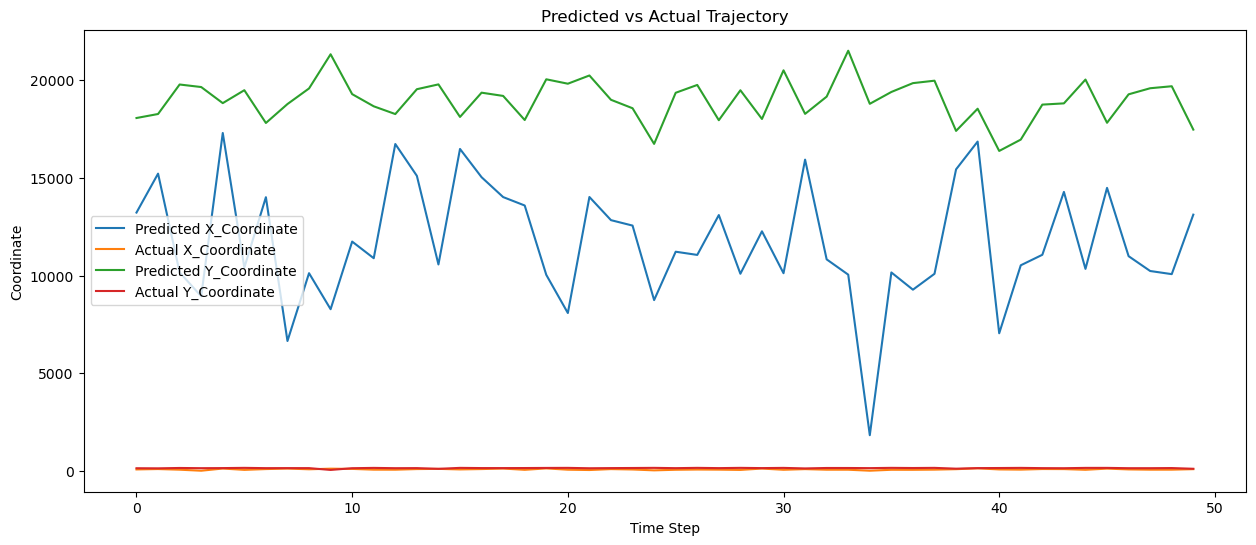

In [36]:
import matplotlib.pyplot as plt

# Convert the test predictions and actual values back to original scale
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Plotting the first N test samples for clarity
N = 50  # Number of samples to plot
plt.figure(figsize=(15, 6))
plt.plot(test_predictions_rescaled[:N, 0], label='Predicted X_Coordinate')
plt.plot(y_test_rescaled[:N, 0], label='Actual X_Coordinate')
plt.plot(test_predictions_rescaled[:N, 1], label='Predicted Y_Coordinate')
plt.plot(y_test_rescaled[:N, 1], label='Actual Y_Coordinate')
plt.title('Predicted vs Actual Trajectory')
plt.xlabel('Time Step')
plt.ylabel('Coordinate')
plt.legend()
plt.show()


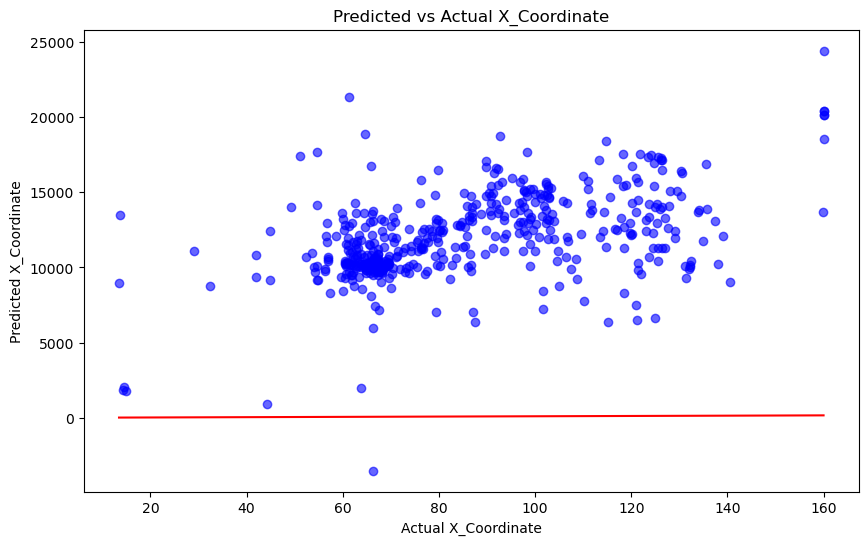

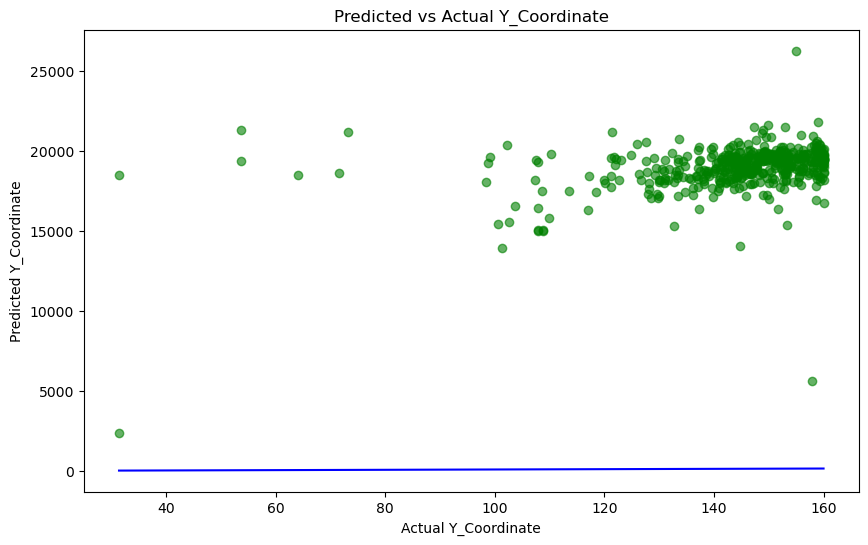

In [38]:
import matplotlib.pyplot as plt

# Assuming test_predictions_tensor and y_test_rescaled are already defined and correctly rescaled

# Plotting for X_Coordinate
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled[:, 0], test_predictions_rescaled[:, 0], color='blue', alpha=0.6)
plt.title('Predicted vs Actual X_Coordinate')
plt.xlabel('Actual X_Coordinate')
plt.ylabel('Predicted X_Coordinate')
plt.plot([min(y_test_rescaled[:, 0]), max(y_test_rescaled[:, 0])], 
         [min(y_test_rescaled[:, 0]), max(y_test_rescaled[:, 0])], 
         color='red')  # Line y = x for reference
plt.show()

# Plotting for Y_Coordinate
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled[:, 1], test_predictions_rescaled[:, 1], color='green', alpha=0.6)
plt.title('Predicted vs Actual Y_Coordinate')
plt.xlabel('Actual Y_Coordinate')
plt.ylabel('Predicted Y_Coordinate')
plt.plot([min(y_test_rescaled[:, 1]), max(y_test_rescaled[:, 1])], 
         [min(y_test_rescaled[:, 1]), max(y_test_rescaled[:, 1])], 
         color='blue')  # Line y = x for reference
plt.show()


In [1]:
# To USE

import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.FloatTensor(xs), torch.FloatTensor(ys)

# LSTM Model Class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Load data
file_path = r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\TrainedRcnnmodel\golf_swings_dataset.xlsx'
df = pd.read_excel(file_path)

# Selecting relevant columns and normalize
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = scaler.fit_transform(df[['X_Coordinate', 'Y_Coordinate']])

# Creating sequences
seq_length = 5
X, y = create_sequences(df_normalized, seq_length)

# Check the first few sequences and labels
print("Sample sequences and corresponding labels:")
for i in range(3):
    print(f"X[{i}]: {X[i]}, y[{i}]: {y[i]}")

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
input_size = 2  # Number of features (X_Coordinate, Y_Coordinate)
hidden_layer_size = 50
output_size = 2
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 150
for epoch in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        seq, labels = seq.view(seq_length, 1, -1).float(), labels.float()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

# After training, test the model
model.eval()
test_predictions = []
for seq in X_test:
    with torch.no_grad():
        seq = seq.view(seq_length, 1, -1).float()
        test_predictions.append(model(seq))

# Rescale predictions and ground truth to original scale
test_predictions_rescaled = scaler.inverse_transform(torch.vstack(test_predictions).numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Check the first few test predictions and ground truth
print("Sample test predictions and ground truth:")
for i in range(3):
    print(f"Predicted: {test_predictions_rescaled[i]}, Actual: {y_test_rescaled[i]}")


C:\Users\sharm\AppData\Local\Temp\ipykernel_8628\1929669185.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.FloatTensor(xs), torch.FloatTensor(ys)


Sample sequences and corresponding labels:
X[0]: tensor([[0.6043, 0.8388],
        [0.5528, 0.7722],
        [0.5849, 0.8703],
        [0.6039, 0.8536],
        [0.5868, 0.8805]]), y[0]: tensor([0.5941, 0.7478])
X[1]: tensor([[0.5528, 0.7722],
        [0.5849, 0.8703],
        [0.6039, 0.8536],
        [0.5868, 0.8805],
        [0.5941, 0.7478]]), y[1]: tensor([0.6633, 0.8364])
X[2]: tensor([[0.5849, 0.8703],
        [0.6039, 0.8536],
        [0.5868, 0.8805],
        [0.5941, 0.7478],
        [0.6633, 0.8364]]), y[2]: tensor([0.5983, 0.7876])
epoch: 0 loss: 0.0082353875041008
epoch: 25 loss: 0.005788425914943218
epoch: 50 loss: 0.004901970271021128
epoch: 75 loss: 0.004891145974397659
epoch: 100 loss: 0.003503166139125824
epoch: 125 loss: 0.004180369898676872
Sample test predictions and ground truth:
Predicted: [ 85.363556 137.4733  ], Actual: [ 79.892265 133.3261  ]
Predicted: [ 84.824104 150.6981  ], Actual: [ 83.01887 152.19879]
Predicted: [ 85.46331 141.51845], Actual: [127.80837 

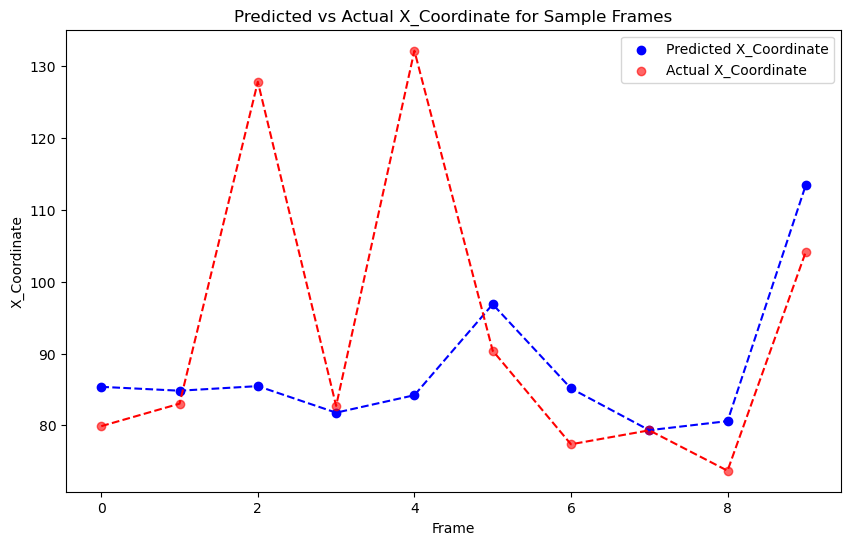

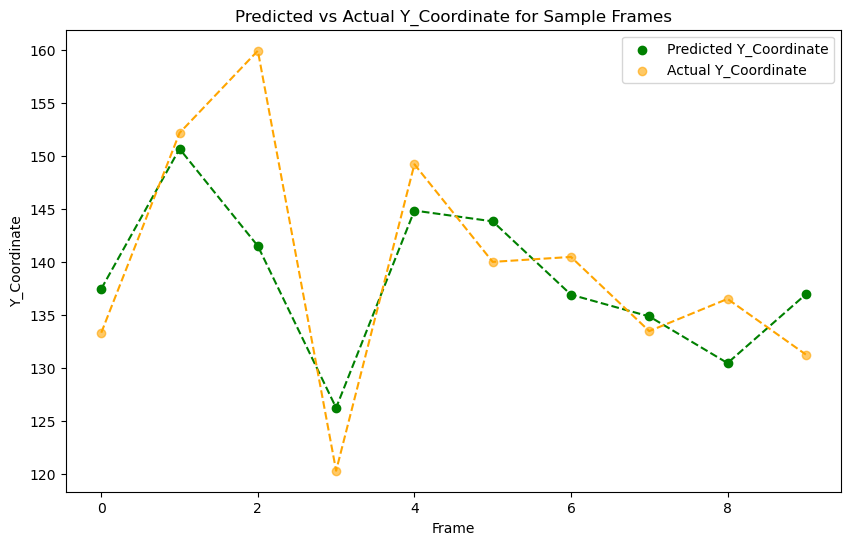

In [2]:
# To USE

import matplotlib.pyplot as plt

# Assuming you have test_predictions_rescaled and y_test_rescaled from the earlier code

# Select a sample of 10 frames
num_samples = 10
sample_indices = range(num_samples)  # You can change this to select different samples

# Extract the corresponding predictions and actual values
sample_predictions = test_predictions_rescaled[sample_indices]
sample_actual = y_test_rescaled[sample_indices]

# Plot for X_Coordinate
plt.figure(figsize=(10, 6))
plt.scatter(range(num_samples), sample_predictions[:, 0], label='Predicted X_Coordinate', color='blue')
plt.scatter(range(num_samples), sample_actual[:, 0], label='Actual X_Coordinate', color='red', alpha=0.6)
plt.plot(range(num_samples), sample_predictions[:, 0], color='blue', linestyle='--')
plt.plot(range(num_samples), sample_actual[:, 0], color='red', linestyle='--')
plt.title('Predicted vs Actual X_Coordinate for Sample Frames')
plt.xlabel('Frame')
plt.ylabel('X_Coordinate')
plt.legend()
plt.show()

# Plot for Y_Coordinate
plt.figure(figsize=(10, 6))
plt.scatter(range(num_samples), sample_predictions[:, 1], label='Predicted Y_Coordinate', color='green')
plt.scatter(range(num_samples), sample_actual[:, 1], label='Actual Y_Coordinate', color='orange', alpha=0.6)
plt.plot(range(num_samples), sample_predictions[:, 1], color='green', linestyle='--')
plt.plot(range(num_samples), sample_actual[:, 1], color='orange', linestyle='--')
plt.title('Predicted vs Actual Y_Coordinate for Sample Frames')
plt.xlabel('Frame')
plt.ylabel('Y_Coordinate')
plt.legend()
plt.show()


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming test_predictions_rescaled and y_test_rescaled are your model's predictions and actual values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_rescaled, test_predictions_rescaled)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 255.39588928222656
Root Mean Squared Error (RMSE): 15.981110572814941
Mean Absolute Error (MAE): 9.478515625


In [4]:
import torch
model_path = 'D:\\Assignments\\MSCourseProject\\GolfClubImageTrainingModel\\TrainedLSTMModel\CoordinatePathModel.pth'
torch.save(model, model_path)

In [57]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the average coordinates in the training set
average_coordinates = np.mean(y_train.numpy(), axis=0)

# Use these averages as predictions for the test set
baseline_predictions = np.tile(average_coordinates, (len(y_test), 1))

# Rescale the baseline predictions back to original scale
baseline_predictions_rescaled = scaler.inverse_transform(baseline_predictions)

# Evaluate the baseline model
baseline_mse = mean_squared_error(y_test_rescaled, baseline_predictions_rescaled)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test_rescaled, baseline_predictions_rescaled)

print(f"Baseline Mean Squared Error (MSE): {baseline_mse}")
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")
print(f"Baseline Mean Absolute Error (MAE): {baseline_mae}")

# Compare with LSTM model's performance
print("\nLSTM Model Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Baseline Mean Squared Error (MSE): 433.25665283203125
Baseline Root Mean Squared Error (RMSE): 20.814817428588867
Baseline Mean Absolute Error (MAE): 13.941927909851074

LSTM Model Performance:
Mean Squared Error (MSE): 229.63951110839844
Root Mean Squared Error (RMSE): 15.153861045837402
Mean Absolute Error (MAE): 9.177454948425293


In [44]:
# Version 2

In [58]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.FloatTensor(xs), torch.FloatTensor(ys)

# LSTM Model Class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Get the output for the last time step
        return predictions


# Load data
file_path = r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\TrainedRcnnmodel\golf_swings_dataset.xlsx'
df = pd.read_excel(file_path)

# Selecting relevant columns and normalize
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = scaler.fit_transform(df[['X_Coordinate', 'Y_Coordinate']])

# Creating sequences
seq_length = 5
X, y = create_sequences(df_normalized, seq_length)

# Check the first few sequences and labels
print("Sample sequences and corresponding labels:")
for i in range(3):
    print(f"X[{i}]: {X[i]}, y[{i}]: {y[i]}")

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
input_size = 2  # Number of features (X_Coordinate, Y_Coordinate)
hidden_layer_size = 100  # Increased hidden layer size
dropout = 0.3  # Added dropout for regularization
learning_rate = 0.005  # Adjusted learning rate
epochs = 200  # Increased number of epochs
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        seq, labels = seq.view(seq_length, 1, -1).float(), labels.float()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

# After training, test the model
model.eval()
test_predictions = []
for seq in X_test:
    with torch.no_grad():
        seq = seq.view(seq_length, 1, -1).float()
        test_predictions.append(model(seq))

# Rescale predictions and ground truth to original scale
test_predictions_rescaled = scaler.inverse_transform(torch.vstack(test_predictions).numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Check the first few test predictions and ground truth
print("Sample test predictions and ground truth:")
for i in range(3):
    print(f"Predicted: {test_predictions_rescaled[i]}, Actual: {y_test_rescaled[i]}")


Sample sequences and corresponding labels:
X[0]: tensor([[0.6043, 0.8388],
        [0.5528, 0.7722],
        [0.5849, 0.8703],
        [0.6039, 0.8536],
        [0.5868, 0.8805]]), y[0]: tensor([0.5941, 0.7478])
X[1]: tensor([[0.5528, 0.7722],
        [0.5849, 0.8703],
        [0.6039, 0.8536],
        [0.5868, 0.8805],
        [0.5941, 0.7478]]), y[1]: tensor([0.6633, 0.8364])
X[2]: tensor([[0.5849, 0.8703],
        [0.6039, 0.8536],
        [0.5868, 0.8805],
        [0.5941, 0.7478],
        [0.6633, 0.8364]]), y[2]: tensor([0.5983, 0.7876])


D:\Tools\Anaconda\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
D:\Tools\Anaconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([5, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss: 0.015392499975860119
epoch: 25 loss: 0.011177364736795425
epoch: 50 loss: 0.01096232421696186
epoch: 75 loss: 0.010931543074548244
epoch: 100 loss: 0.010923216119408607
epoch: 125 loss: 0.010820725932717323
epoch: 150 loss: 0.010654197074472904
epoch: 175 loss: 0.010518606752157211
Sample test predictions and ground truth:
Predicted: [ 90.745964 139.40079 ], Actual: [ 79.892265 133.3261  ]
Predicted: [ 82.82811 142.86891], Actual: [ 83.01887 152.19879]
Predicted: [ 85.58446 140.6895 ], Actual: [127.80837 159.96484]


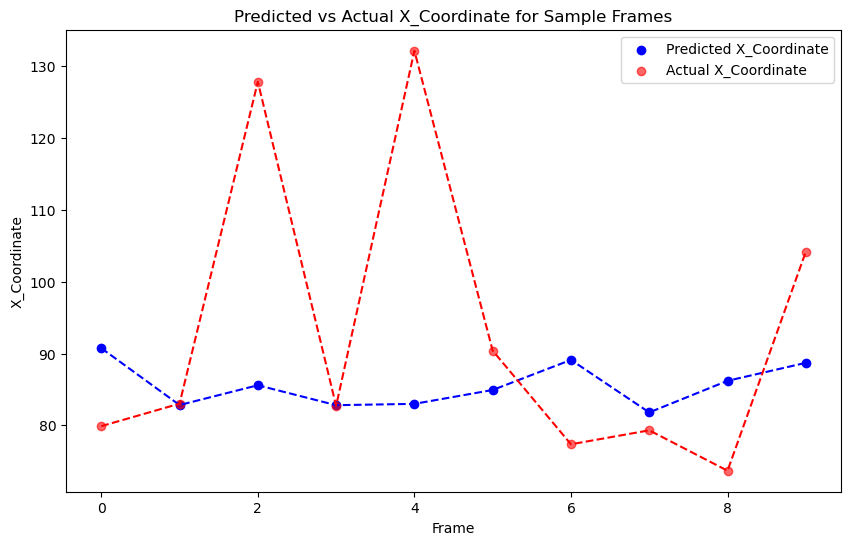

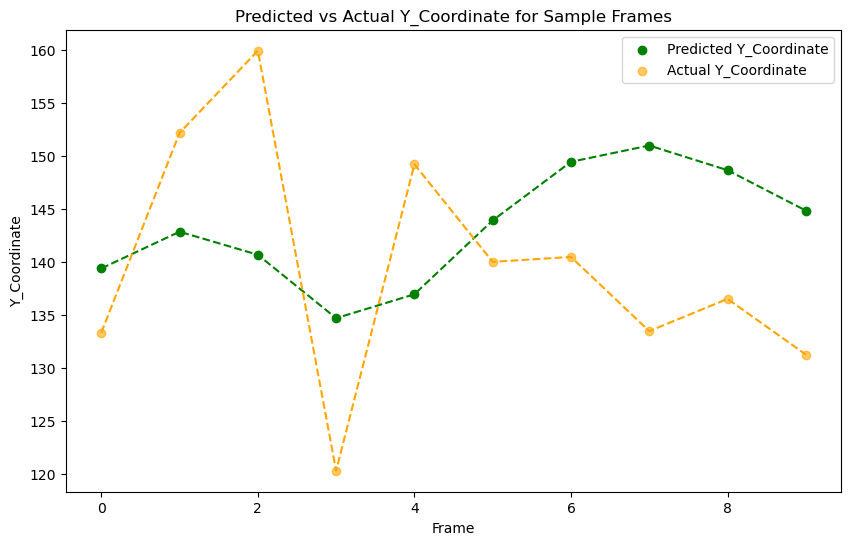

In [59]:
import matplotlib.pyplot as plt

# Assuming you have test_predictions_rescaled and y_test_rescaled from the earlier code

# Select a sample of 10 frames
num_samples = 10
sample_indices = range(num_samples)  # You can change this to select different samples

# Extract the corresponding predictions and actual values
sample_predictions = test_predictions_rescaled[sample_indices]
sample_actual = y_test_rescaled[sample_indices]

# Plot for X_Coordinate
plt.figure(figsize=(10, 6))
plt.scatter(range(num_samples), sample_predictions[:, 0], label='Predicted X_Coordinate', color='blue')
plt.scatter(range(num_samples), sample_actual[:, 0], label='Actual X_Coordinate', color='red', alpha=0.6)
plt.plot(range(num_samples), sample_predictions[:, 0], color='blue', linestyle='--')
plt.plot(range(num_samples), sample_actual[:, 0], color='red', linestyle='--')
plt.title('Predicted vs Actual X_Coordinate for Sample Frames')
plt.xlabel('Frame')
plt.ylabel('X_Coordinate')
plt.legend()
plt.show()

# Plot for Y_Coordinate
plt.figure(figsize=(10, 6))
plt.scatter(range(num_samples), sample_predictions[:, 1], label='Predicted Y_Coordinate', color='green')
plt.scatter(range(num_samples), sample_actual[:, 1], label='Actual Y_Coordinate', color='orange', alpha=0.6)
plt.plot(range(num_samples), sample_predictions[:, 1], color='green', linestyle='--')
plt.plot(range(num_samples), sample_actual[:, 1], color='orange', linestyle='--')
plt.title('Predicted vs Actual Y_Coordinate for Sample Frames')
plt.xlabel('Frame')
plt.ylabel('Y_Coordinate')
plt.legend()
plt.show()


In [60]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the average coordinates in the training set
average_coordinates = np.mean(y_train.numpy(), axis=0)

# Use these averages as predictions for the test set
baseline_predictions = np.tile(average_coordinates, (len(y_test), 1))

# Rescale the baseline predictions back to original scale
baseline_predictions_rescaled = scaler.inverse_transform(baseline_predictions)

# Evaluate the baseline model
baseline_mse = mean_squared_error(y_test_rescaled, baseline_predictions_rescaled)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test_rescaled, baseline_predictions_rescaled)

print(f"Baseline Mean Squared Error (MSE): {baseline_mse}")
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")
print(f"Baseline Mean Absolute Error (MAE): {baseline_mae}")

# Compare with LSTM model's performance
print("\nLSTM Model Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Baseline Mean Squared Error (MSE): 433.25665283203125
Baseline Root Mean Squared Error (RMSE): 20.814817428588867
Baseline Mean Absolute Error (MAE): 13.941927909851074

LSTM Model Performance:
Mean Squared Error (MSE): 229.63951110839844
Root Mean Squared Error (RMSE): 15.153861045837402
Mean Absolute Error (MAE): 9.177454948425293


In [48]:
# Version 3

In [49]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.FloatTensor(xs), torch.FloatTensor(ys)

# LSTM Model Class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions


# Load data
file_path = r'D:\Assignments\MSCourseProject\GolfClubImageTrainingModel\TrainedRcnnmodel\golf_swings_dataset.xlsx'
df = pd.read_excel(file_path)

# Selecting relevant columns and normalize
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = scaler.fit_transform(df[['X_Coordinate', 'Y_Coordinate']])

# Creating sequences
seq_length = 5
X, y = create_sequences(df_normalized, seq_length)

# Check the first few sequences and labels
print("Sample sequences and corresponding labels:")
for i in range(3):
    print(f"X[{i}]: {X[i]}, y[{i}]: {y[i]}")

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
input_size = 2  # Number of features (X_Coordinate, Y_Coordinate)
hidden_layer_size = 50  # Adjust as needed
dropout = 0.2  # Lower dropout
learning_rate = 0.001  # Experiment with this
epochs = 200  # Adjust based on performance
model = LSTMModel(input_size, hidden_layer_size, output_size, dropout=dropout)


# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        seq, labels = seq.view(seq_length, 1, -1).float(), labels.float()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

# After training, test the model
model.eval()
test_predictions = []
for seq in X_test:
    with torch.no_grad():
        seq = seq.view(seq_length, 1, -1).float()
        test_predictions.append(model(seq))

# Rescale predictions and ground truth to original scale
test_predictions_rescaled = scaler.inverse_transform(torch.vstack(test_predictions).numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Check the first few test predictions and ground truth
print("Sample test predictions and ground truth:")
for i in range(3):
    print(f"Predicted: {test_predictions_rescaled[i]}, Actual: {y_test_rescaled[i]}")


Sample sequences and corresponding labels:
X[0]: tensor([[0.5828, 0.8072],
        [0.5285, 0.7277],
        [0.5624, 0.8449],
        [0.5824, 0.8250],
        [0.5643, 0.8572]]), y[0]: tensor([0.5721, 0.6985])
X[1]: tensor([[0.5285, 0.7277],
        [0.5624, 0.8449],
        [0.5824, 0.8250],
        [0.5643, 0.8572],
        [0.5721, 0.6985]]), y[1]: tensor([0.6450, 0.8044])
X[2]: tensor([[0.5624, 0.8449],
        [0.5824, 0.8250],
        [0.5643, 0.8572],
        [0.5721, 0.6985],
        [0.6450, 0.8044]]), y[2]: tensor([0.5765, 0.7460])


D:\Tools\Anaconda\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
D:\Tools\Anaconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([5, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss: 0.01705627515912056
epoch: 25 loss: 0.023380357772111893
epoch: 50 loss: 0.0245260838419199
epoch: 75 loss: 0.025353416800498962
epoch: 100 loss: 0.026000410318374634
epoch: 125 loss: 0.026385381817817688
epoch: 150 loss: 0.02663840353488922
epoch: 175 loss: 0.02690182998776436
Sample test predictions and ground truth:
Predicted: [ 81.35076 148.41634], Actual: [ 79.293495 141.12605 ]
Predicted: [ 83.47279 145.51062], Actual: [ 99.01933 135.8027 ]
Predicted: [ 80.977585 148.85555 ], Actual: [ 66.169586 154.06044 ]


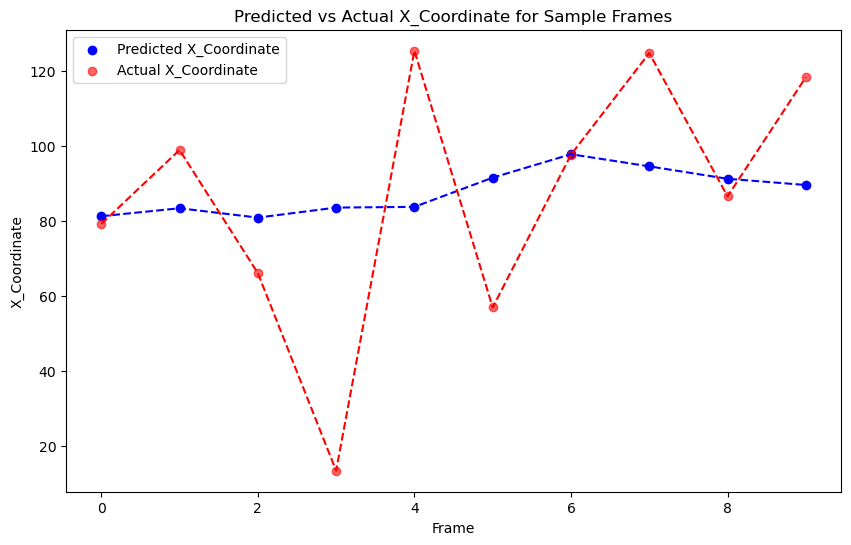

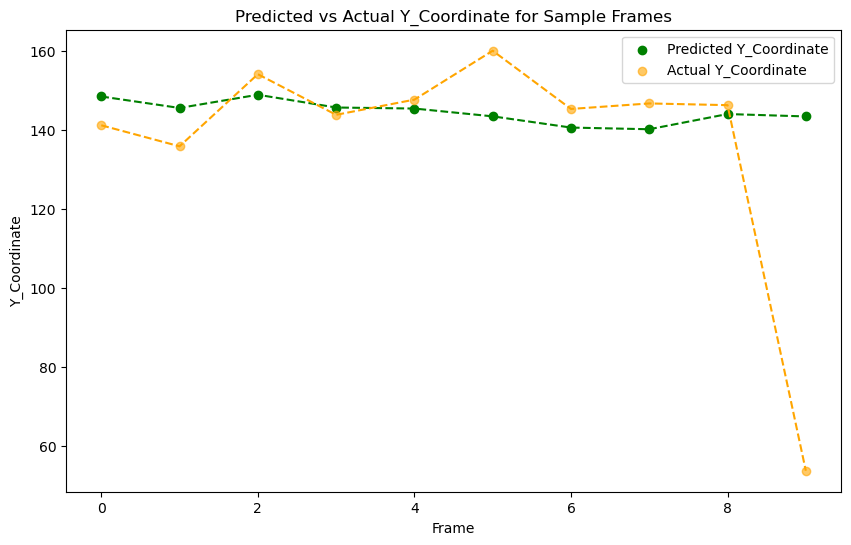

In [50]:
import matplotlib.pyplot as plt

# Assuming you have test_predictions_rescaled and y_test_rescaled from the earlier code

# Select a sample of 10 frames
num_samples = 10
sample_indices = range(num_samples)  # You can change this to select different samples

# Extract the corresponding predictions and actual values
sample_predictions = test_predictions_rescaled[sample_indices]
sample_actual = y_test_rescaled[sample_indices]

# Plot for X_Coordinate
plt.figure(figsize=(10, 6))
plt.scatter(range(num_samples), sample_predictions[:, 0], label='Predicted X_Coordinate', color='blue')
plt.scatter(range(num_samples), sample_actual[:, 0], label='Actual X_Coordinate', color='red', alpha=0.6)
plt.plot(range(num_samples), sample_predictions[:, 0], color='blue', linestyle='--')
plt.plot(range(num_samples), sample_actual[:, 0], color='red', linestyle='--')
plt.title('Predicted vs Actual X_Coordinate for Sample Frames')
plt.xlabel('Frame')
plt.ylabel('X_Coordinate')
plt.legend()
plt.show()

# Plot for Y_Coordinate
plt.figure(figsize=(10, 6))
plt.scatter(range(num_samples), sample_predictions[:, 1], label='Predicted Y_Coordinate', color='green')
plt.scatter(range(num_samples), sample_actual[:, 1], label='Actual Y_Coordinate', color='orange', alpha=0.6)
plt.plot(range(num_samples), sample_predictions[:, 1], color='green', linestyle='--')
plt.plot(range(num_samples), sample_actual[:, 1], color='orange', linestyle='--')
plt.title('Predicted vs Actual Y_Coordinate for Sample Frames')
plt.xlabel('Frame')
plt.ylabel('Y_Coordinate')
plt.legend()
plt.show()


In [51]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the average coordinates in the training set
average_coordinates = np.mean(y_train.numpy(), axis=0)

# Use these averages as predictions for the test set
baseline_predictions = np.tile(average_coordinates, (len(y_test), 1))

# Rescale the baseline predictions back to original scale
baseline_predictions_rescaled = scaler.inverse_transform(baseline_predictions)

# Evaluate the baseline model
baseline_mse = mean_squared_error(y_test_rescaled, baseline_predictions_rescaled)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test_rescaled, baseline_predictions_rescaled)

print(f"Baseline Mean Squared Error (MSE): {baseline_mse}")
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")
print(f"Baseline Mean Absolute Error (MAE): {baseline_mae}")

# Compare with LSTM model's performance
print("\nLSTM Model Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Baseline Mean Squared Error (MSE): 486.318359375
Baseline Root Mean Squared Error (RMSE): 22.052627563476562
Baseline Mean Absolute Error (MAE): 16.082902908325195

LSTM Model Performance:
Mean Squared Error (MSE): 390.9258117675781
Root Mean Squared Error (RMSE): 19.7718448638916
Mean Absolute Error (MAE): 12.75354290008545


In [5]:
!pip install --upgrade onnx onnxscript

  Obtaining dependency information for onnx from https://files.pythonhosted.org/packages/db/2d/0851d7bb5ae1d08cc27a0ccfba9e77e2393f47ea56e57d347e2926b6d316/onnx-1.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for onnxscript from https://files.pythonhosted.org/packages/58/df/1f960843050fb8fd9677b84ae287cb7237710f2005285efd8e5b93312ca6/onnxscript-0.1.0.dev20231130-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   - -------------------------------------- 0.4/14.3 MB 7.4 MB/s eta 0:00:02
   -- ------------------------------------- 0.9/14.3 MB 9.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.7/14.3 MB 12.0 MB/s eta 0:00:02
   ------- -------------------------------- 2.8/14.3 MB 15.1 MB/s eta 0:00:01
   ----------- ---------------------------- 4.2/14.3 MB 17.9 MB/s eta 0:00:01
   -------------- ------------------------- 5.2/14.3 MB 18.6 MB/s eta 0:00:01
   -------------------- ------------------- 

In [7]:
import torch.onnx

# Example: export the PyTorch model to ONNX
dummy_input = torch.randn(1, input_size)  # Provide a dummy input
torch.onnx.export(model, dummy_input, "D:\\Assignments\\MSCourseProject\\GolfClubImageTrainingModel\\TrainedLSTMModel\CoordinatePredictionModel.onnx")


C:\Users\sharm\AppData\Local\Temp\ipykernel_8628\1929669185.py:29: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  predictions = self.linear(lstm_out.view(len(input_seq), -1))
